# Assignment 3

### Scott Thoesen
### OPTI 556

# Initialization Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist


# Section 1

Simulate coded aperture imaging with a 59 by 59 element coding mask using the MURA coding strategy. Try linear reconstruction of various images, try adding noise at various levels, discuss the results that you seek.

### Quadratic residues

In [ ]:
def qres(p):
  #function to find the quadratic residues modulo prime number p between 1
  # and p-1. The function returns a list with value 1 for all indices which
  # are quadratic residues modulo p and value 0 for indices which are not
  # quadratic residues.
  #
  qr=np.zeros(p)
  for i in range(1,p):
    qr[np.mod(i**2,p)-1]=1
  return qr


### 59x59 MURA Coded Pattern

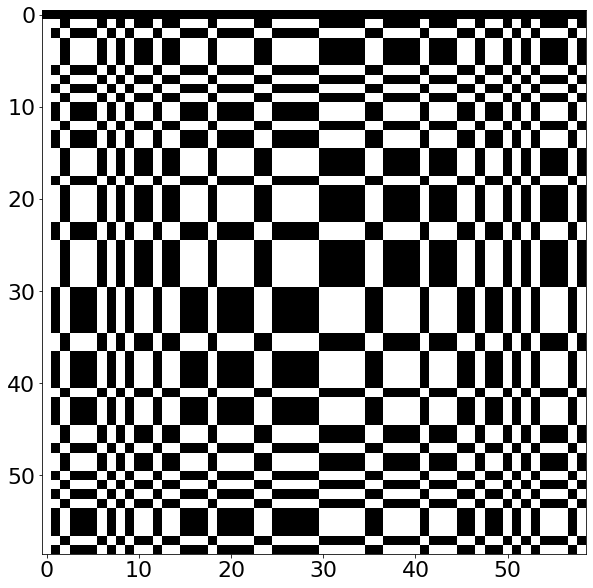

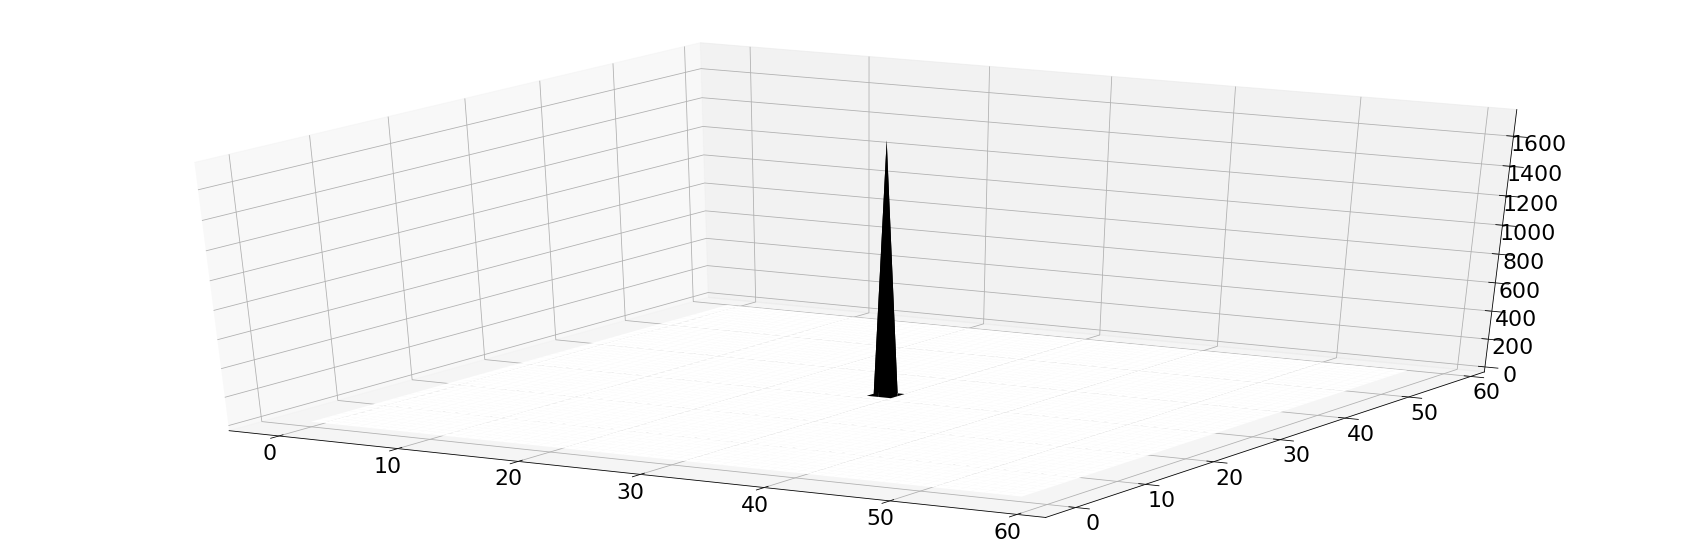

In [ ]:
p=59
qr=qres(p)
t=np.zeros((p,p));
t[1:p,0]=1;
for i in range(1,p):
    for j in range(1,p):
        if qr[i-1]==qr[j-1]:
            t[i,j]=1;
tt=np.vstack((np.hstack((t,t)),np.hstack((t,t))))
ht=2*(t-0.5)
ht[0,0]=1;
cp=signal.convolve2d(ht,t, mode='same',boundary='wrap');
#plt.subplot(1,2,1);
plt.imshow(t,cmap='gray');
#plt.title('Base aperture pattern')
#plt.subplot(1,2,2);
#plt.imshow(tt, cmap='gray');
#plt.title('Tiled aperture pattern')
#plt.savefig('muraCodedAperture31.pdf')
#files.download('muraCodedAperture31.pdf')
fig=plt.figure()

ax = plt.gca(projection='3d')

X, Y = np.meshgrid(range(np.shape(cp)[1]), range(np.shape(cp)[0]))


surf = ax.plot_surface(X, Y, cp, rstride=1, cstride=1, antialiased=True, cmap='binary')
#plt.title('Cross Corelation with Decoding Pattern')

#plt.savefig('muraCodedApertureCorrelation.pdf')
#files.download('muraCodedApertureCorrelation.pdf')



## Measuring and reconstructing images

In [ ]:
# load the mnist dataset of characters
(train, test), (train_l, test_l) = cifar10.load_data()
train=train.astype("float32")/255.0
test=test.astype("float32")/255.0

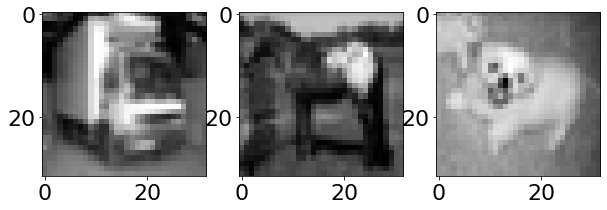

In [ ]:
plt.rcParams['figure.figsize'] = [10,10]
plt.subplot(1,3,1);
plt.imshow(train[2001].mean(axis=2),cmap='gray')

plt.subplot(1,3,2);
plt.imshow(train[1900].mean(axis=2),cmap='gray')

plt.subplot(1,3,3);
plt.imshow(train[7000].mean(axis=2),cmap='gray')

### Reconstruction without noise

(-0.5, 31.5, 31.5, -0.5)

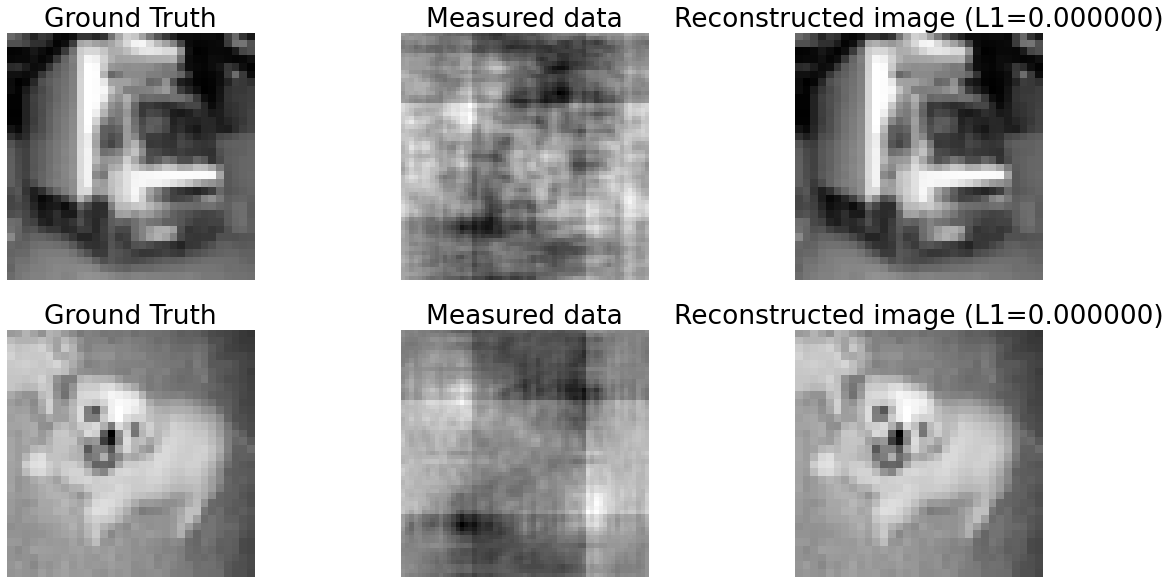

In [ ]:
croplen = int(np.floor((p - 32)/2))

plt.rcParams['figure.figsize'] = [20, 10]
# we consider coded apeture imaging of images drawn from the mnist data set of hand drawn digits
noiseFactor=10;
signalNoise=0; #%1 for noise, 0 for no signal noise

imagey=train[2001].mean(axis=2);

# Step 1 generate projected pattern
g=signal.convolve2d(t,imagey, mode='same',boundary='wrap');
#The following line adds signal dependent noise
#photonsPerPixel=100000
#g=np.random.poisson(photonsPerPixel*g/np.max(g))
plt.subplot(2,3,1);
plt.imshow(imagey,cmap='gray')
plt.title('Ground Truth');
plt.axis('off')
plt.subplot(2,3,2);
plt.imshow(g,cmap='gray')
plt.title('Measured data');
plt.axis('off')
plt.subplot(2,3,3);
fe=signal.convolve2d(ht,g, mode='same',boundary='wrap');
fe = fe[croplen+2:croplen+34, croplen+2:croplen+34]
fe = fe/cp.max()
plt.imshow(fe, cmap='gray');

L1 = sum(sum(abs(fe-imagey)))

plt.title('Reconstructed image (L1=%f)' %L1);
plt.axis('off')

imagey=train[7000].mean(axis=2);

# Step 1 generate projected pattern
g=signal.convolve2d(t,imagey, mode='same',boundary='wrap');
#The following line adds signal dependent noise
#photonsPerPixel=100000
#g=np.random.poisson(photonsPerPixel*g/np.max(g))
plt.subplot(2,3,4);
plt.imshow(imagey,cmap='gray')
plt.title('Ground Truth');
plt.axis('off')
plt.subplot(2,3,5);
plt.imshow(g,cmap='gray')
plt.title('Measured data');
plt.axis('off')
plt.subplot(2,3,6);
fe=signal.convolve2d(ht,g, mode='same',boundary='wrap');
fe = fe[croplen+2:croplen+34, croplen+2:croplen+34]
fe = fe/cp.max()
plt.imshow(fe, cmap='gray');

L1 = sum(sum(abs(fe-imagey)))

plt.title('Reconstructed image (L1=%f)' %L1);
plt.axis('off')

#plt.savefig('muraCodedApertureReconNoNoise.pdf')
#files.download('muraCodedApertureReconNoNoise.pdf')


#### Remarks

The images above are measured by convolving them with a 59x59 MURA coded pattern. These coded images are then decoded by convolving them with the decoding matrix. Since the coded pattern and decoding matrix are delta-correlated with a large peak response, the final output must be normalized. This normalization value is 1740, which corresponds to the number of blocked holes in the pattern. 

As is seen by the L1 distance, both output images are perfect reconstructions. This was expected.

### Reconstruction with poisson noise

#### Peak Flux: 10 Photons

(-0.5, 31.5, 31.5, -0.5)

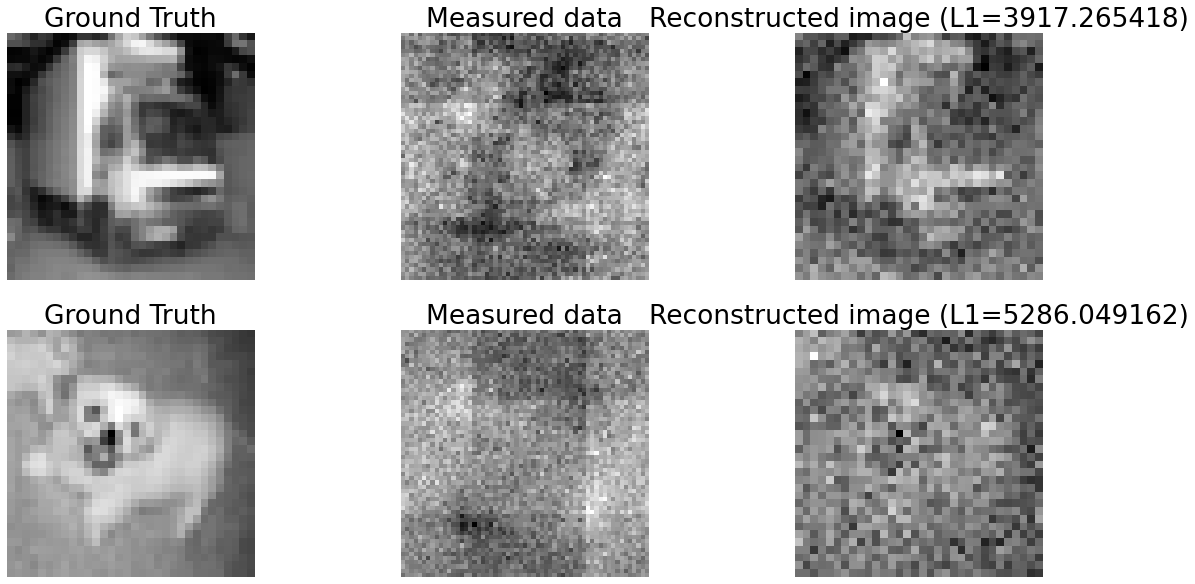

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
# we consider coded apeture imaging of images drawn from the mnist data set of hand drawn digits
noiseFactor=10;
signalNoise=0; #%1 for noise, 0 for no signal noise

imagey=train[2001].mean(axis=2);

# Step 1 generate projected pattern
g=signal.convolve2d(t,imagey, mode='same',boundary='wrap');
#The following line adds signal dependent noise
photonsPerPixel=10
g=np.random.poisson(photonsPerPixel*g)
plt.subplot(2,3,1);
plt.imshow(imagey,cmap='gray')
plt.title('Ground Truth');
plt.axis('off')
plt.subplot(2,3,2);
plt.imshow(g,cmap='gray')
plt.title('Measured data');
plt.axis('off')
plt.subplot(2,3,3);
fe=signal.convolve2d(ht,g, mode='same',boundary='wrap');
fe = fe[croplen+2:croplen+34, croplen+2:croplen+34]
fe = fe/cp.max()
plt.imshow(fe, cmap='gray');

L1 = sum(sum(abs(fe-imagey)))

plt.title('Reconstructed image (L1=%f)' %L1);
plt.axis('off')

imagey=train[7000].mean(axis=2);

# Step 1 generate projected pattern
g=signal.convolve2d(t,imagey, mode='same',boundary='wrap');
#The following line adds signal dependent noise
#plt.savefig('muraCodedApertureReconShotNoise.pdf')
#files.download('muraCodedApertureReconShotNoise.pdf')
g=np.random.poisson(photonsPerPixel*g)
plt.subplot(2,3,4);
plt.imshow(imagey,cmap='gray')
plt.title('Ground Truth');
plt.axis('off')
plt.subplot(2,3,5);
plt.imshow(g,cmap='gray')
plt.title('Measured data');
plt.axis('off')
plt.subplot(2,3,6);
fe=signal.convolve2d(ht,g, mode='same',boundary='wrap');
fe = fe[croplen+2:croplen+34, croplen+2:croplen+34]
fe = fe/cp.max()
plt.imshow(fe, cmap='gray');

L1 = sum(sum(abs(fe-imagey)))

plt.title('Reconstructed image (L1=%f)' %L1)
plt.axis('off')

#plt.savefig('muraCodedApertureReconShotNoise.pdf')
#files.download('muraCodedApertureReconShotNoise.pdf')

#### Peak Flux: 100 Photons

(-0.5, 31.5, 31.5, -0.5)

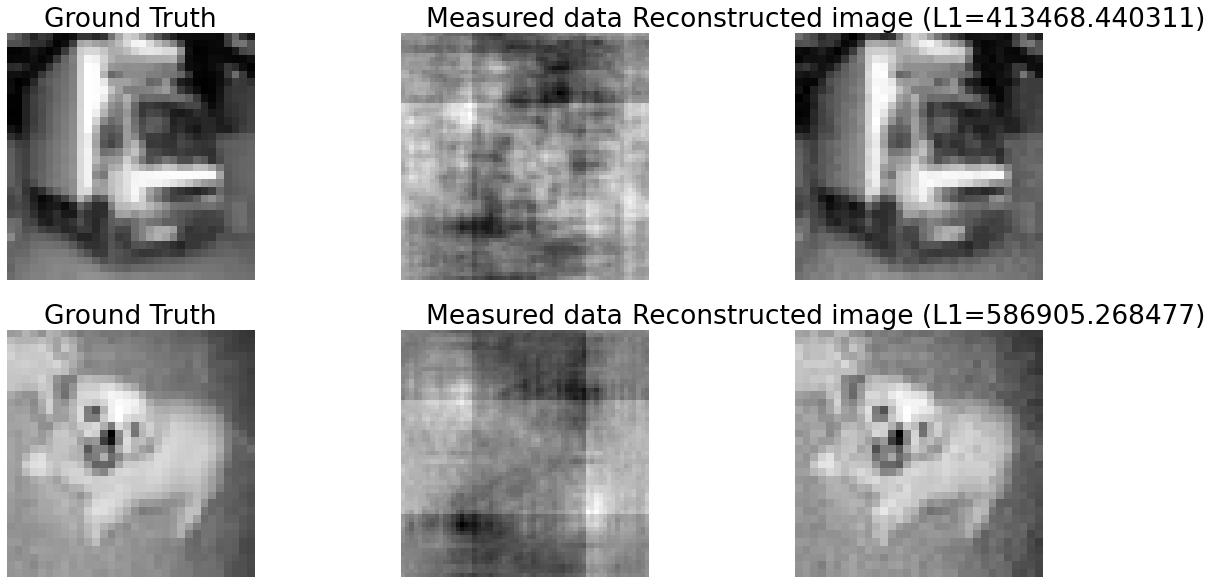

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
# we consider coded apeture imaging of images drawn from the mnist data set of hand drawn digits
noiseFactor=10;
signalNoise=0; #%1 for noise, 0 for no signal noise

imagey=train[2001].mean(axis=2);

# Step 1 generate projected pattern
g=signal.convolve2d(t,imagey, mode='same',boundary='wrap');
#The following line adds signal dependent noise
photonsPerPixel=1000
g=np.random.poisson(photonsPerPixel*g)
plt.subplot(2,3,1);
plt.imshow(imagey,cmap='gray')
plt.title('Ground Truth');
plt.axis('off')
plt.subplot(2,3,2);
plt.imshow(g,cmap='gray')
plt.title('Measured data');
plt.axis('off')
plt.subplot(2,3,3);
fe=signal.convolve2d(ht,g, mode='same',boundary='wrap');
fe = fe[croplen+2:croplen+34, croplen+2:croplen+34]
fe = fe/cp.max()
plt.imshow(fe, cmap='gray');

L1 = sum(sum(abs(fe-imagey)))

plt.title('Reconstructed image (L1=%f)' %L1);
plt.axis('off')

imagey=train[7000].mean(axis=2);

# Step 1 generate projected pattern
g=signal.convolve2d(t,imagey, mode='same',boundary='wrap');
#The following line adds signal dependent noise
#plt.savefig('muraCodedApertureReconShotNoise.pdf')
#files.download('muraCodedApertureReconShotNoise.pdf')
g=np.random.poisson(photonsPerPixel*g)
plt.subplot(2,3,4);
plt.imshow(imagey,cmap='gray')
plt.title('Ground Truth');
plt.axis('off')
plt.subplot(2,3,5);
plt.imshow(g,cmap='gray')
plt.title('Measured data');
plt.axis('off')
plt.subplot(2,3,6);
fe=signal.convolve2d(ht,g, mode='same',boundary='wrap');
fe = fe[croplen+2:croplen+34, croplen+2:croplen+34]
fe = fe/cp.max()
plt.imshow(fe, cmap='gray');

L1 = sum(sum(abs(fe-imagey)))

plt.title('Reconstructed image (L1=%f)' %L1)
plt.axis('off')

#plt.savefig('muraCodedApertureReconShotNoise.pdf')
#files.download('muraCodedApertureReconShotNoise.pdf')

#### Remarks

It's clear from the above images that MURA codes are pretty sensitive to Poisson noise. Even at a modest 1000 photons/pixel, the reconstruction of a sparse image sees a lot of noise.

# Section 2

Implement neural denoising of the system that you built in 1. To complete 1 you will need to scale images to work well with the 59 element code. You  may need to rescale images to match parameters of your neural denoising system. Try several different neural processing models (e.g. different numbers of layers, add drop layers, max pooling layers). Look for classes of images that perform well or not well in the neural denoiser. 

## Model 1

This model will use the CIFAR-10 image database and utilize only the mammal classes of images for training and testing. The neural net is unchanged from the example. Poisson noise is added to the training/test images assuming a peak flux of 100 photons/pixel.

### Import and Condition Images

In [ ]:
(x_train0, train_l), (x_test0, test_l) = cifar10.load_data()
x_train0=x_train0.astype("float32")/255.0
x_test0=x_test0.astype("float32")/255.0

x_test=np.zeros((4000,32,32))
x_train=np.zeros((20000,32,32))
g_test=np.zeros(x_test.shape)
g_train=np.zeros(x_train.shape)

i = 0;
for pop in range(np.shape(x_test0)[0]):
  if (test_l[pop] == 3) or  (test_l[pop] == 4) or (test_l[pop] == 5) or (test_l[pop] == 7):
    x_test[i,:,:] = cv2.cvtColor(x_test0[pop,:,:,:], cv2.COLOR_BGR2GRAY)
    g_test[i,:,:]=signal.convolve2d(ht,np.random.poisson(100*signal.convolve2d(t,x_test[i,:,:], mode='same',boundary='wrap'))\
                                                  ,mode='same',boundary='wrap')[croplen+2:croplen+34, croplen+2:croplen+34]
    g_test[i,:,:]=g_test[i,:,:]/np.max(g_test[i,:,:])
    i += 1;

i = 0;
for pop in range(np.shape(x_train0)[0]):
  if (train_l[pop] == 3) or  (train_l[pop] == 4) or (train_l[pop] == 5) or (train_l[pop] == 7):
    x_train[i,:,:] = cv2.cvtColor(x_train0[pop,:,:,:], cv2.COLOR_BGR2GRAY)
    g_train[i,:,:]=signal.convolve2d(ht,np.random.poisson(100*signal.convolve2d(t,x_train[i,:,:], mode='same',boundary='wrap'))\
                                                  ,mode='same',boundary='wrap')[croplen+2:croplen+34, croplen+2:croplen+34]
    g_train[i,:,:]=g_train[i,:,:]/np.max(g_train[i,:,:])
    i += 1;
x_train = np.reshape(x_train, (len(x_train), 32, 32, 1))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 1))
g_train = np.reshape(g_train, (len(g_train), 32, 32, 1))
g_test = np.reshape(g_test, (len(g_test), 32, 32, 1))

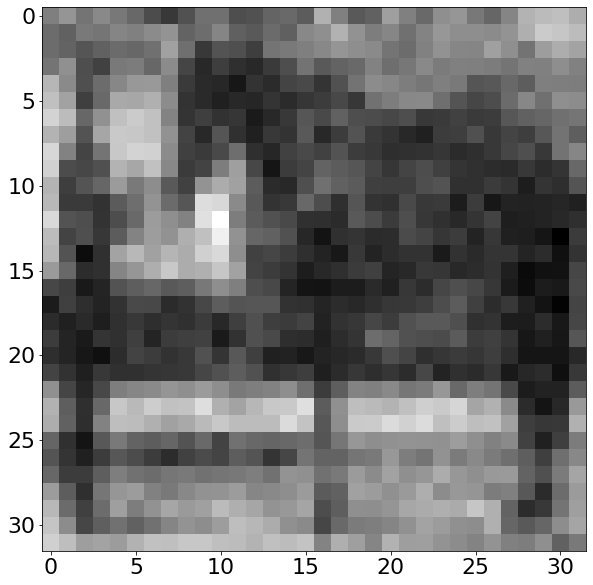

In [ ]:

#mean_squared_error(x_train[7000,:,:,0],g_train[7000,:,:,0])
plt.imshow(g_train[7000].reshape(32, 32), cmap='gray')

In [ ]:
!wget --no-check-certificate https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s2_1.tar.gz
!tar -xzvf autoencoder_s2_1.tar.gz
autoencoder_s2_1 = keras.models.load_model('autoencoder_s2_1/')

### Encoder/denoising model

In [ ]:
input_img = keras.Input(shape=(32, 32, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_s2_1 = keras.Model(input_img, decoded)
autoencoder_s2_1.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_s2_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 32)          9248

### Training

In [ ]:

autoencoder_s2_1.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
157/157 [==============================] - 12s 10ms/step - loss: 0.6110 - val_loss: 0.5982
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5934 - val_loss: 0.5919
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5899 - val_loss: 0.5896
Epoch 4/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5888 - val_loss: 0.5886
Epoch 5/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5872 - val_loss: 0.5882
Epoch 6/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5865 - val_loss: 0.5871
Epoch 7/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5861 - val_loss: 0.5869
Epoch 8/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5852 - val_loss: 0.5858
Epoch 9/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5847 - val_loss: 0.5854
Epoch 10/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5847 - val_loss: 0.58

In [ ]:
!rm -r autoencoder_s2_1/
autoencoder_s2_1.save("autoencoder_s2_1")
!tar -czvf autoencoder_s2_1.tar.gz autoencoder_s2_1/
files.download('autoencoder_s2_1.tar.gz')

rm: cannot remove 'autoencoder_s2_1/': No such file or directory
autoencoder_s2_1/
autoencoder_s2_1/variables/
autoencoder_s2_1/variables/variables.index
autoencoder_s2_1/variables/variables.data-00000-of-00001
autoencoder_s2_1/assets/
autoencoder_s2_1/saved_model.pb
autoencoder_s2_1/keras_metadata.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Examples of noisy and denoised images

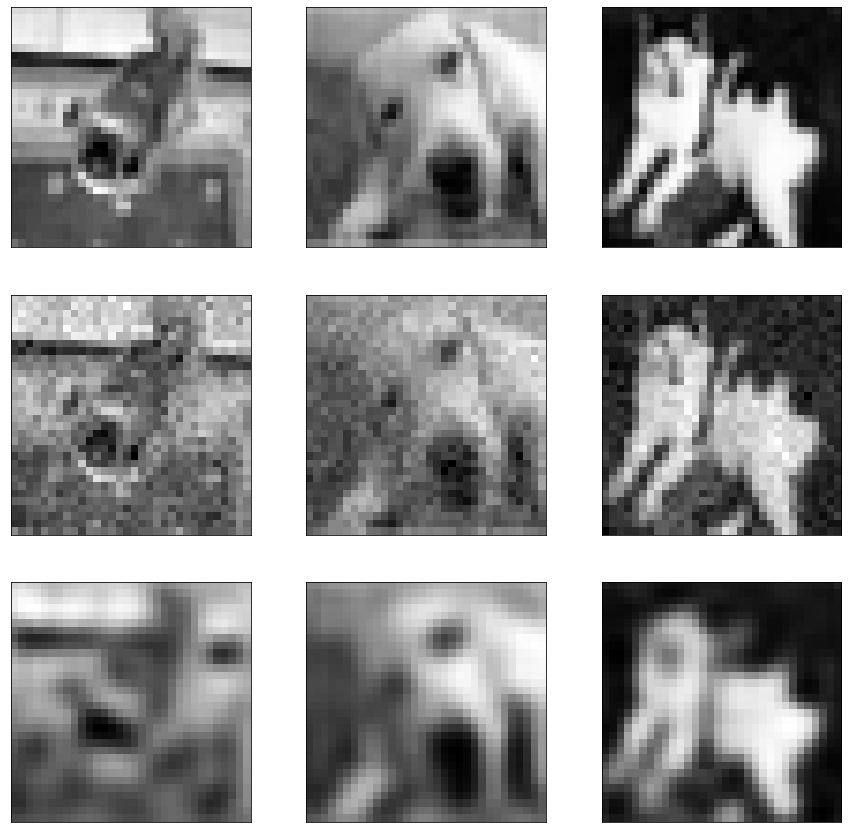

In [ ]:

n = 3
plt.figure(figsize=(15, 15))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i*1000].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i*1000].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_s2_1.predict(g_test[i*1000:i*1000+1,:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.savefig('muraCodedApertureNeuralDenoise.pdf')
#files.download('muraCodedApertureNeuralDenoise.pdf')

### Remarks

This model was very interesting. On one hand, it did a good job of reducing noise; on the other hand, reconstructed images are missing features. The model smoothed out a lot of textures and the results are over done. I would say that having a convolution chain with interspaced max pooling layers, followed by normal upsampling layers, has the effect of low-pass filtering images via some sort of decimation/interpolation. If this is the case, then I can see how an overly ambitious net can pull noise out as well as other high-frequency content to include sharp features.

## Model 2

This model will use the same images from Model 1. The neural net is the same as the example except the Conv2D+UpSampling2D layers are replaced with Conv2DTranspose.

In [ ]:
!wget --no-check-certificate https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s2_2.tar.gz
!tar -xzvf autoencoder_s2_2.tar.gz
autoencoder_s2_2 = keras.models.load_model('autoencoder_s2_2/')

### Encoder/denoising model

In [ ]:
input_img = keras.Input(shape=(32, 32, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
#x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_s2_2 = keras.Model(input_img, decoded)
autoencoder_s2_2.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_s2_2.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_156 (Conv2D)         (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_115 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_157 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 conv2d_transpose_131 (Conv2  (None, 32, 32, 32)       9248      
 DTranspose)                                                     
                                                                 
 conv2d_158 (Conv2D)         (None, 32, 32, 1)         289

### Training

In [ ]:

autoencoder_s2_2.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
157/157 [==============================] - 2s 10ms/step - loss: 0.6056 - val_loss: 0.5896
Epoch 2/10
157/157 [==============================] - 1s 9ms/step - loss: 0.5866 - val_loss: 0.5876
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5852 - val_loss: 0.5884
Epoch 4/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5838 - val_loss: 0.5851
Epoch 5/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5831 - val_loss: 0.5860
Epoch 6/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5826 - val_loss: 0.5831
Epoch 7/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5821 - val_loss: 0.5831
Epoch 8/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5817 - val_loss: 0.5835
Epoch 9/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5815 - val_loss: 0.5832
Epoch 10/10
157/157 [==============================] - 1s 8ms/step - loss: 0.5812 - val_loss: 0.582

In [ ]:
!rm -r autoencoder_s2_2/
autoencoder_s2_2.save("autoencoder_s2_2")
!tar -czvf autoencoder_s2_2.tar.gz autoencoder_s2_2/
files.download('autoencoder_s2_2.tar.gz')

autoencoder_s2_2/
autoencoder_s2_2/variables/
autoencoder_s2_2/variables/variables.index
autoencoder_s2_2/variables/variables.data-00000-of-00001
autoencoder_s2_2/assets/
autoencoder_s2_2/saved_model.pb
autoencoder_s2_2/keras_metadata.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Examples of noisy and denoised images

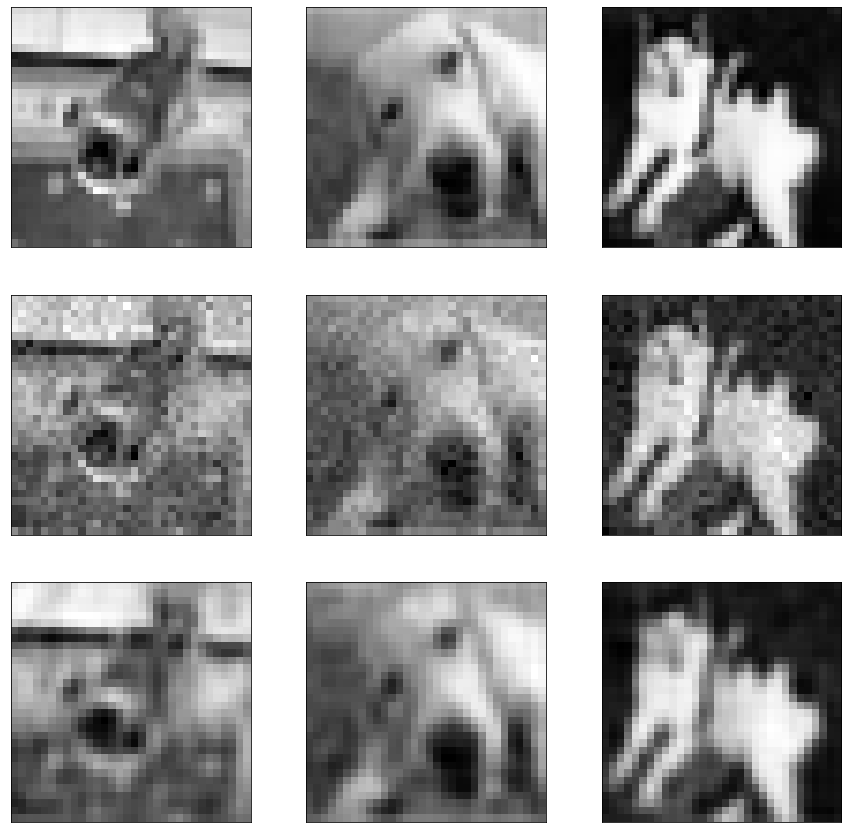

In [ ]:

n = 3
plt.figure(figsize=(15, 15))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i*1000].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i*1000].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_s2_2.predict(g_test[i*1000:i*1000+1,:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.savefig('muraCodedApertureNeuralDenoise.pdf')
#files.download('muraCodedApertureNeuralDenoise.pdf')

### Remarks

This model takes the Model 1 architecture and substitutes upsampling for a convolution transpose layer. This simple alteration resulted in completely different image reconstructions. Much of the noise is removed, a lot of texture is recovered, and important features are preserved. If I understand this layer type correctly, it performs a similar task to upsampling/convolution except the model gets to learn more than being told what to do. In this case, the model seemed to have flexibility to learn not to low pass filter when low pass filtering wasn't needed.

Different layers and numbers of filters were attempted but did not perform as well as what is shown above. Additionally, the final sigmoid activation layer was changed to linear and performance dropped. The loss function was also changed to mean squared error and performance dropped as well.

## Model 3

This model will use the same images from Model 1. The neural net is the same as the example except for the addition of a dropout layer.

In [ ]:
!wget --no-check-certificate https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s2_3.tar.gz
!tar -xzvf autoencoder_s2_3.tar.gz
autoencoder_s2_3 = keras.models.load_model('autoencoder_s2_3/')

### Encoder/denoising model

In [ ]:
input_img = keras.Input(shape=(32, 32, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.Dropout(0.1)(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_s2_3 = keras.Model(input_img, decoded)
autoencoder_s2_3.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_s2_3.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_159 (Conv2D)         (None, 32, 32, 32)        320       
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_117 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_160 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 conv2d_transpose_132 (Conv2  (None, 32, 32, 32)       9248      
 DTranspose)                                              

### Training

In [ ]:

autoencoder_s2_3.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
157/157 [==============================] - 2s 11ms/step - loss: 0.6094 - val_loss: 0.5910
Epoch 2/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5870 - val_loss: 0.5867
Epoch 3/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5846 - val_loss: 0.5862
Epoch 4/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5840 - val_loss: 0.5849
Epoch 5/10
157/157 [==============================] - 1s 10ms/step - loss: 0.5830 - val_loss: 0.5863
Epoch 6/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5826 - val_loss: 0.5839
Epoch 7/10
157/157 [==============================] - 1s 10ms/step - loss: 0.5823 - val_loss: 0.5841
Epoch 8/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5821 - val_loss: 0.5845
Epoch 9/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5818 - val_loss: 0.5839
Epoch 10/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5820 - val_lo

In [ ]:
!rm -r autoencoder_s2_3/
autoencoder_s2_3.save("autoencoder_s2_3")
!tar -czvf autoencoder_s2_3.tar.gz autoencoder_s2_3/
files.download('autoencoder_s2_3.tar.gz')

rm: cannot remove 'autoencoder_s2_3/': No such file or directory
autoencoder_s2_3/
autoencoder_s2_3/variables/
autoencoder_s2_3/variables/variables.index
autoencoder_s2_3/variables/variables.data-00000-of-00001
autoencoder_s2_3/assets/
autoencoder_s2_3/saved_model.pb
autoencoder_s2_3/keras_metadata.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Examples of noisy and denoised images

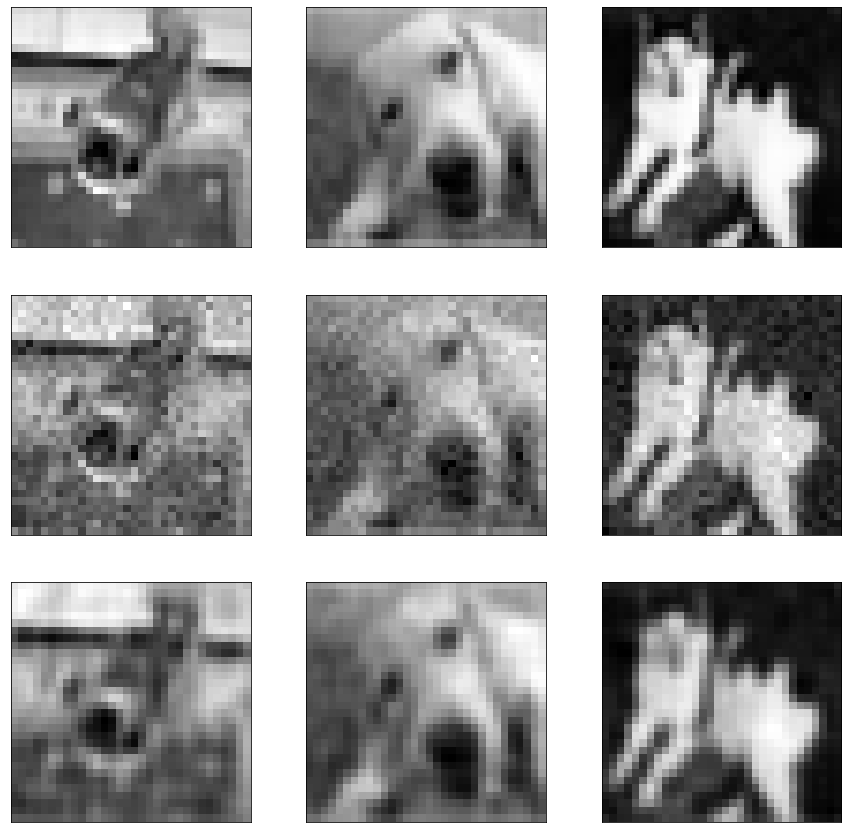

In [ ]:

n = 3
plt.figure(figsize=(15, 15))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i*1000].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i*1000].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_s2_3.predict(g_test[i*1000:i*1000+1,:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.savefig('muraCodedApertureNeuralDenoise.pdf')
#files.download('muraCodedApertureNeuralDenoise.pdf')

### Remarks

This model takes the Model 2 architecture and adds a dropout layer after the first convolutional layer. The dropout layer was also tried after the inputs layer. In both cases, performance declined slightly. Decreasing dropout rate improved performance but did not improve it over Model 2.

## Model 4

This model will use the same images from Model 1. The neural net is a U-NET architecture.

In [ ]:
!wget --no-check-certificate https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s2_4.tar.gz
!tar -xzvf autoencoder_s2_4.tar.gz
autoencoder_s2_4 = keras.models.load_model('autoencoder_s2_4/')

### Encoder/denoising model

In [ ]:
inputs = keras.Input(shape=(32, 32, 1))

# Encoder
x1 = layers.Conv2D(32, (2, 2), strides=2, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2))(x1)
x2 = layers.Conv2D(32, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x2)
x3 = layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x3)
# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,x3])
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,x2])
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,x1])
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,inputs])
x = layers.Conv2D(16, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder_s2_4 = keras.Model(inputs, x)
autoencoder_s2_4.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_s2_4.summary()

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_162 (Conv2D)            (None, 16, 16, 32)   160         ['input_42[0][0]']               
                                                                                                  
 max_pooling2d_119 (MaxPooling2  (None, 8, 8, 32)    0           ['conv2d_162[0][0]']             
 D)                                                                                               
                                                                                                  
 conv2d_163 (Conv2D)            (None, 8, 8, 32)     9248        ['max_pooling2d_119[0][0]'

In [ ]:
keras.utils.plot_model(autoencoder_s2_3)

### Training

In [ ]:

autoencoder_s2_4.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
157/157 [==============================] - 3s 13ms/step - loss: 0.0282 - val_loss: 0.0089
Epoch 2/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 3/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 4/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 5/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 6/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 7/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 8/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 9/10
157/157 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 10/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0051 - val_los

In [ ]:
!rm -r autoencoder_s2_4/
autoencoder_s2_4.save("autoencoder_s2_4")
!tar -czvf autoencoder_s2_4.tar.gz autoencoder_s2_4/
files.download('autoencoder_s2_4.tar.gz')

rm: cannot remove 'autoencoder_s2_4/': No such file or directory
autoencoder_s2_4/
autoencoder_s2_4/variables/
autoencoder_s2_4/variables/variables.index
autoencoder_s2_4/variables/variables.data-00000-of-00001
autoencoder_s2_4/assets/
autoencoder_s2_4/saved_model.pb
autoencoder_s2_4/keras_metadata.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Examples of noisy and denoised images

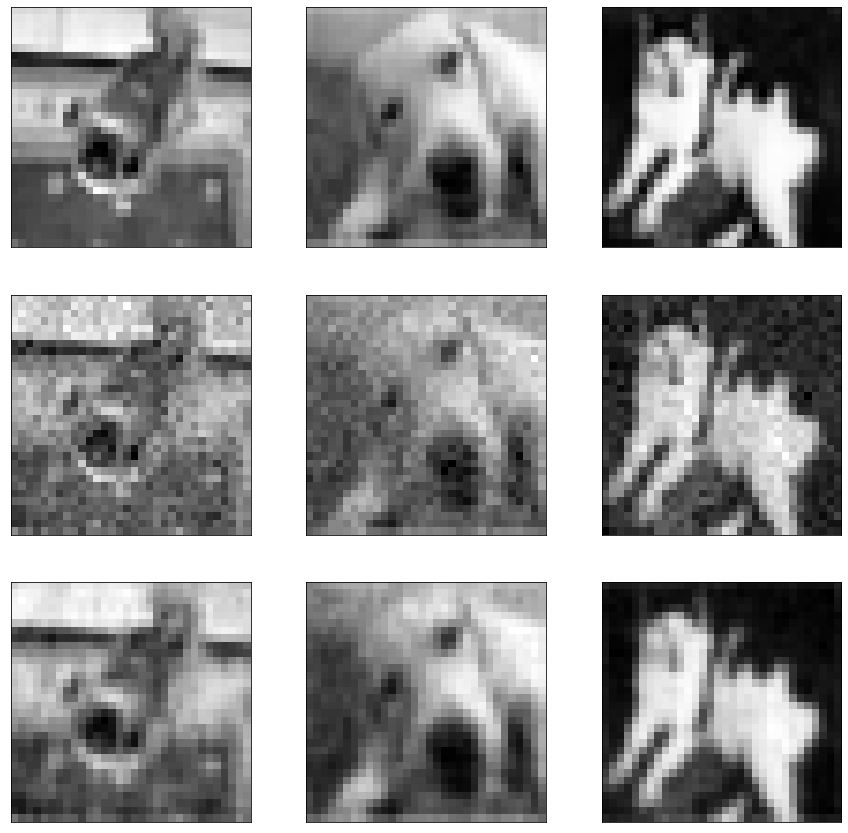

In [ ]:

n = 3
plt.figure(figsize=(15, 15))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i*1000].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i*1000].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_s2_4.predict(g_test[i*1000:i*1000+1,:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.savefig('muraCodedApertureNeuralDenoise.pdf')
#files.download('muraCodedApertureNeuralDenoise.pdf')

### Remarks

This model is a U-NET with 3 convolutional layers. This was added just as an alternative architecture to compare performance. This model does a very good job of preserving features and textures but clearly at the expense of not fully eliminating noise.

It is possible a tradespace exists here. Low-resolution images with a lot of content can appear noisy to begin with. It seems like neural processing may have a limit in being able to distinguish cruddy, low-resolution features from noise; it has to pick between keeping features at the risk of keeping some noise, or eliminating features in order to eliminate noise.

# Section 3

Test and compare neural reconstruction from sparse radon data for several different neural architectures. Make a report analyzing the performance of systems presented in https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/projectionTomography.ipynb, see if you can improve on the results presented there. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from skimage.transform import radon, rescale,  resize, warp
from scipy import interpolate
from skimage.transform import iradon_sart

## load mnist data set as example images

In [4]:
from keras.datasets import mnist
# load the mnist dataset of characters
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


## modified iradon function

In [5]:
from scipy.interpolate import interp1d
from scipy.constants import golden_ratio
from skimage.transform._warps import warp
from skimage.transform._radon_transform import sart_projection_update
from skimage._shared.fft import fftmodule
from skimage._shared.utils import  convert_to_float
from warnings import warn
from functools import partial

if fftmodule is np.fft:
    # fallback from scipy.fft to scipy.fftpack instead of numpy.fft
    # (fftpack preserves single precision while numpy.fft does not)
    from scipy.fftpack import fft, ifft
else:
    fft = fftmodule.fft
    ifft = fftmodule.ifft
    
def iradon(radon_image, theta=None, output_size=None,
           filter_name="ramp", interpolation="linear", circle=True,
           preserve_range=True):
    """Inverse radon transform.

    Reconstruct an image from the radon transform, using the filtered
    back projection algorithm.

    Parameters
    ----------
    radon_image : array
        Image containing radon transform (sinogram). Each column of
        the image corresponds to a projection along a different
        angle. The tomography rotation axis should lie at the pixel
        index ``radon_image.shape[0] // 2`` along the 0th dimension of
        ``radon_image``.
    theta : array_like, optional
        Reconstruction angles (in degrees). Default: m angles evenly spaced
        between 0 and 180 (if the shape of `radon_image` is (N, M)).
    output_size : int, optional
        Number of rows and columns in the reconstruction.
    filter_name : str, optional
        Filter used in frequency domain filtering. Ramp filter used by default.
        Filters available: ramp, shepp-logan, cosine, hamming, hann.
        Assign None to use no filter.
    interpolation : str, optional
        Interpolation method used in reconstruction. Methods available:
        'linear', 'nearest', and 'cubic' ('cubic' is slow).
    circle : boolean, optional
        Assume the reconstructed image is zero outside the inscribed circle.
        Also changes the default output_size to match the behaviour of
        ``radon`` called with ``circle=True``.
    preserve_range : bool, optional
        Whether to keep the original range of values. Otherwise, the input
        image is converted according to the conventions of `img_as_float`.
        Also see https://scikit-image.org/docs/dev/user_guide/data_types.html

    Returns
    -------
    reconstructed : ndarray
        Reconstructed image. The rotation axis will be located in the pixel
        with indices
        ``(reconstructed.shape[0] // 2, reconstructed.shape[1] // 2)``.

    .. versionchanged :: 0.19
        In ``iradon``, ``filter`` argument is deprecated in favor of
        ``filter_name``.

    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    .. [2] B.R. Ramesh, N. Srinivasa, K. Rajgopal, "An Algorithm for Computing
           the Discrete Radon Transform With Some Applications", Proceedings of
           the Fourth IEEE Region 10 International Conference, TENCON '89, 1989

    Notes
    -----
    It applies the Fourier slice theorem to reconstruct an image by
    multiplying the frequency domain of the filter with the FFT of the
    projection data. This algorithm is called filtered back projection.

    """
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    if theta is None:
        theta = np.linspace(0, 180, radon_image.shape[1], endpoint=False)

    angles_count = len(theta)
    if angles_count != radon_image.shape[1]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")

    interpolation_types = ('linear', 'nearest', 'cubic')
    if interpolation not in interpolation_types:
        raise ValueError("Unknown interpolation: %s" % interpolation)

    filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
    if filter_name not in filter_types:
        raise ValueError("Unknown filter: %s" % filter_name)

    radon_image = convert_to_float(radon_image, preserve_range)
    dtype = radon_image.dtype

    img_shape = radon_image.shape[0]
    if output_size is None:
        # If output size not specified, estimate from input radon image
        if circle:
            output_size = img_shape
        else:
            output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

    if circle:
        radon_image = _sinogram_circle_to_square(radon_image)
        img_shape = radon_image.shape[0]

    # Resize image to next power of two (but no less than 64) for
    # Fourier analysis; speeds up Fourier and lessens artifacts
    projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

    # Apply filter in Fourier domain
    fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(ifft(projection, axis=0)[:img_shape, :])

    # Reconstruct image by interpolation
    reconstructed = np.zeros((output_size, output_size),
                             dtype=dtype)
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interp1d(x, col, kind=interpolation,
                                   bounds_error=False, fill_value=0)
        reconstructed += interpolant(t)

    if circle:
        out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
        reconstructed[out_reconstruction_circle] = 0.

    return reconstructed * np.pi / (2 * angles_count), projection
def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)
def _get_fourier_filter(size, filter_name):
    """Construct the Fourier filter.

    This computation lessens artifacts and removes a small bias as
    explained in [1], Chap 3. Equation 61.

    Parameters
    ----------
    size : int
        filter size. Must be even.
    filter_name : str
        Filter used in frequency domain filtering. Filters available:
        ramp, shepp-logan, cosine, hamming, hann. Assign None to use
        no filter.

    Returns
    -------
    fourier_filter: ndarray
        The computed Fourier filter.

    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.

    """
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                        np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * np.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftmodule.fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftmodule.fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftmodule.fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftmodule.fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]


## Algebraic Reconstruction from Sparse Data

SART (1 iteration) rms reconstruction error: 0.168
SART (1 iteration) rms reconstruction error: 0.158


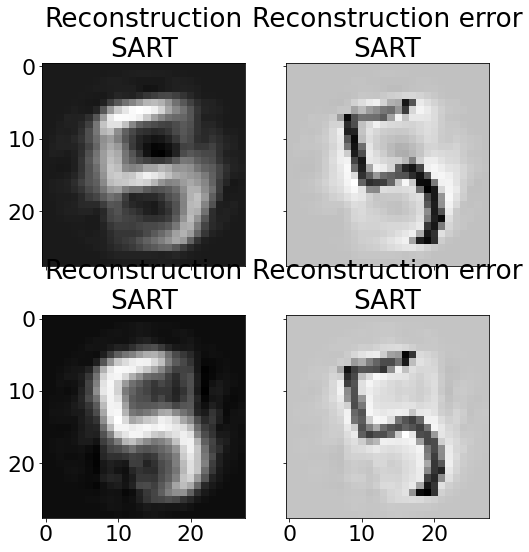

In [ ]:


ntheta=10;
image=x_train[1024,:,:]
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
sinogram=radon(image,thetaVals);
reconstruction_sart = iradon_sart(sinogram, theta=thetaVals)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r)
# no try with regularly spaced samples
thetaVals=np.linspace(0,180,ntheta)
sinogram=radon(image,thetaVals);
reconstruction_sart = iradon_sart(sinogram, theta=thetaVals)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

ax[2].set_title("Reconstruction\nSART")
ax[2].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART")
ax[3].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r)


## Neural compressed sensing

### load and prepare data

In [ ]:
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.


(x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(radon(x_test[pop,:,:],thetaVals), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(radon(x_train[pop,:,:],thetaVals), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

1.0


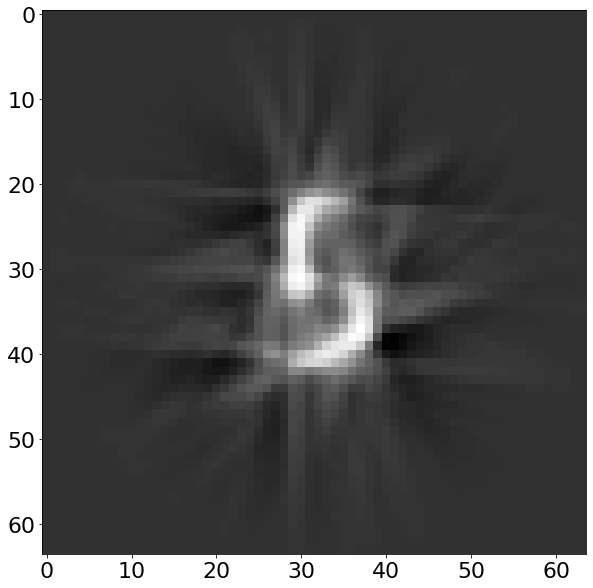

In [ ]:
plt.imshow(g_test[1931].reshape(64, 64), cmap=plt.cm.Greys_r)
print(np.max(g_test[1931]))

In [ ]:
!wget --no-check-certificate https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s3_1.tar.gz
!tar -xzvf autoencoder_s3_1.tar.gz
autoencoder_s3_1 = keras.models.load_model('autoencoder_s3_1/')

### Encoder/denoising model

In [ ]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder_s3_1 = keras.Model(inputs, x)
autoencoder_s3_1.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_s3_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        832       
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                                 

### Training

In [ ]:
autoencoder_s3_1.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 66s 117ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 2/10
469/469 [==============================] - 49s 105ms/step - loss: 9.2307e-04 - val_loss: 7.3209e-04
Epoch 3/10
469/469 [==============================] - 47s 100ms/step - loss: 6.9520e-04 - val_loss: 5.9617e-04
Epoch 4/10
469/469 [==============================] - 52s 111ms/step - loss: 5.8080e-04 - val_loss: 5.2893e-04
Epoch 5/10
469/469 [==============================] - 52s 111ms/step - loss: 5.2219e-04 - val_loss: 4.6702e-04
Epoch 6/10
469/469 [==============================] - 53s 113ms/step - loss: 4.7532e-04 - val_loss: 4.3631e-04
Epoch 7/10
469/469 [==============================] - 53s 113ms/step - loss: 4.4455e-04 - val_loss: 4.2001e-04
Epoch 8/10
469/469 [==============================] - 54s 115ms/step - loss: 4.1793e-04 - val_loss: 4.0104e-04
Epoch 9/10
469/469 [==============================] - 54s 115ms/step - loss: 3.9882e-04 - val_loss: 3.7951e-04
Epoch 10/

In [ ]:
!rm -r autoencoder_s3_1/
autoencoder_s3_1.save("autoencoder_s3_1")
!tar -czvf autoencoder_s3_1.tar.gz autoencoder_s3_1/
files.download('autoencoder_s3_1.tar.gz')

rm: cannot remove 'autoencoder_s3_1/': No such file or directory
autoencoder_s3_1/
autoencoder_s3_1/assets/
autoencoder_s3_1/variables/
autoencoder_s3_1/variables/variables.index
autoencoder_s3_1/variables/variables.data-00000-of-00001
autoencoder_s3_1/keras_metadata.pb
autoencoder_s3_1/saved_model.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Examples of subsampled and estimated images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

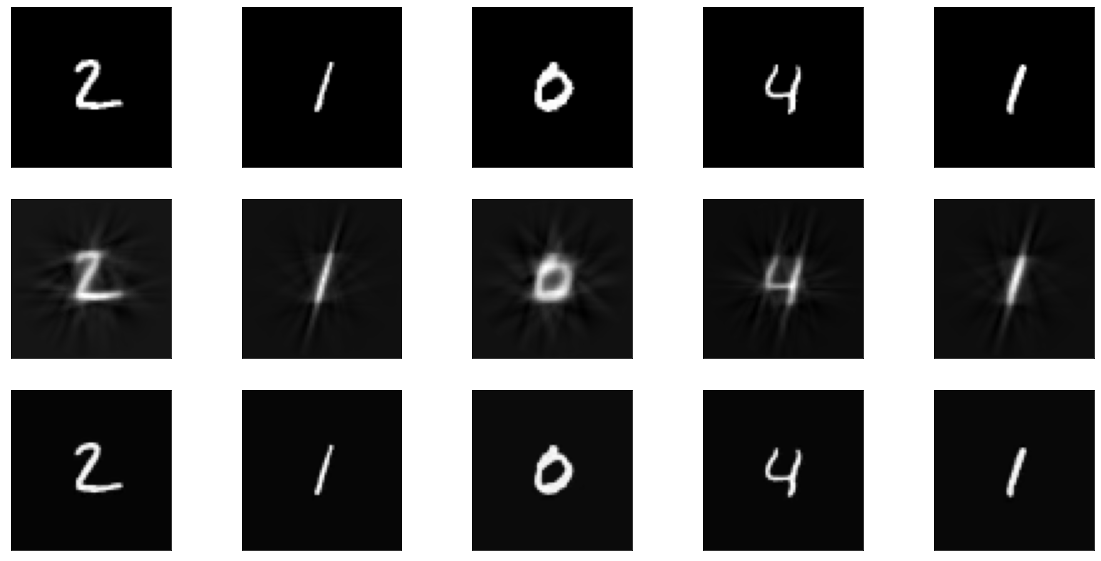

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_s3_1.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.savefig('subSampleSARTNeuralDecompression.pdf')
#files.download('subSampleSARTNeuralDecompression.pdf')

## Neural compressed sensing with noise

### load and prepare data

In [12]:
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
#
# we are going to add poisson noise to the measurements. nPhoto is an gain factor for the intensity of the measured signal
#
nPhoto=1

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_test[pop,:,:],thetaVals))), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_train[pop,:,:],thetaVals))), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

### Model 1

In [8]:
!wget --no-check-certificate https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s3_2.tar.gz
!tar -xzvf autoencoder_s3_2.tar.gz
autoencoder_s3_2 = keras.models.load_model('autoencoder_s3_2/')

--2022-10-12 03:00:46--  https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s3_2.tar.gz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sthoesen/OPTI556/main/assignment3/autoencoder_s3_2.tar.gz [following]
--2022-10-12 03:00:46--  https://raw.githubusercontent.com/sthoesen/OPTI556/main/assignment3/autoencoder_s3_2.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1107451 (1.1M) [application/octet-stream]
Saving to: ‘autoencoder_s3_2.tar.gz’

autoencoder_s3_2.ta 100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2022-10-12 03:00:48 (8.79 MB/s) - ‘autoencoder_s3_

#### Encoder/denoising model

In [14]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder_s3_2 = keras.Model(inputs, x)
autoencoder_s3_2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_s3_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                                   

#### Training

In [15]:
autoencoder_s3_2.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 49s 99ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 2/10
469/469 [==============================] - 42s 89ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 3/10
469/469 [==============================] - 41s 88ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/10
469/469 [==============================] - 43s 91ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 5/10
469/469 [==============================] - 42s 89ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 6/10
469/469 [==============================] - 41s 87ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 7/10
469/469 [==============================] - 43s 92ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/10
469/469 [==============================] - 45s 97ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 9/10
469/469 [==============================] - 40s 86ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/10
469/469 [==============================] - 44s 94ms/step - loss: 0.003

In [ ]:
!rm -r autoencoder_s3_2/
autoencoder_s3_2.save("autoencoder_s3_2")
!tar -czvf autoencoder_s3_2.tar.gz autoencoder_s3_2/
files.download('autoencoder_s3_2.tar.gz')

rm: cannot remove 'autoencoder_s3_2/': No such file or directory
autoencoder_s3_2/
autoencoder_s3_2/assets/
autoencoder_s3_2/variables/
autoencoder_s3_2/variables/variables.index
autoencoder_s3_2/variables/variables.data-00000-of-00001
autoencoder_s3_2/keras_metadata.pb
autoencoder_s3_2/saved_model.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Examples of subsampled and estimated images

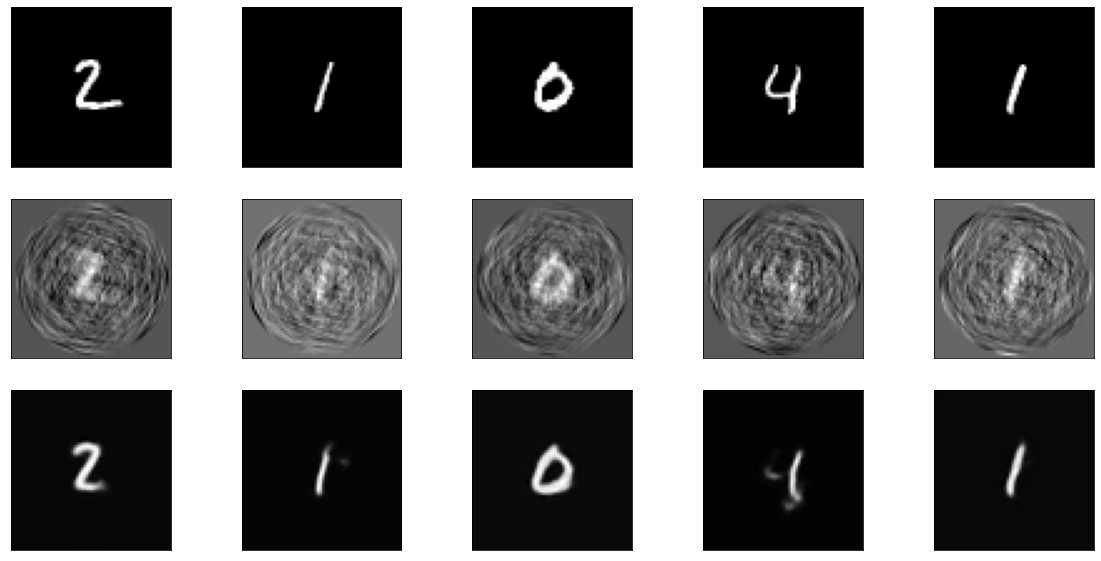

In [16]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_s3_2.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.savefig('subSampleSARTNeuralDecompressionNoise20.pdf')
#files.download('subSampleSARTNeuralDecompressionNoise20.pdf')

#### Remarks

The model does a pretty good job of removing noise as well as other reconstruction artifacts, except in the case of the "4". A few of 4's strokes seem to have been lost in the reconstruction, possibly due to the noise.

### Model 2

#### Encoder/denoising model

In [33]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder_s3_3 = keras.Model(inputs, x)
autoencoder_s3_3.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_s3_3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        832       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        16416     
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        32832     
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 16, 16, 128)      147584    
 Transpose)                                                      
                                                           

#### Training

In [34]:
autoencoder_s3_3.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 38s 78ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 2/10
469/469 [==============================] - 36s 77ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 3/10
469/469 [==============================] - 35s 76ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/10
469/469 [==============================] - 36s 76ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/10
469/469 [==============================] - 35s 76ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/10
469/469 [==============================] - 35s 76ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/10
469/469 [==============================] - 35s 76ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/10
469/469 [==============================] - 35s 75ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/10
469/469 [==============================] - 35s 75ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/10
469/469 [==============================] - 35s 75ms/step - loss: 0.003

In [36]:
!rm -r autoencoder_s3_3/
autoencoder_s3_3.save("autoencoder_s3_3")
!tar -czvf autoencoder_s3_3.tar.gz autoencoder_s3_3/
files.download('autoencoder_s3_3.tar.gz')

autoencoder_s3_3/
autoencoder_s3_3/saved_model.pb
autoencoder_s3_3/keras_metadata.pb
autoencoder_s3_3/assets/
autoencoder_s3_3/variables/
autoencoder_s3_3/variables/variables.index
autoencoder_s3_3/variables/variables.data-00000-of-00001


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Examples of subsampled and estimated images

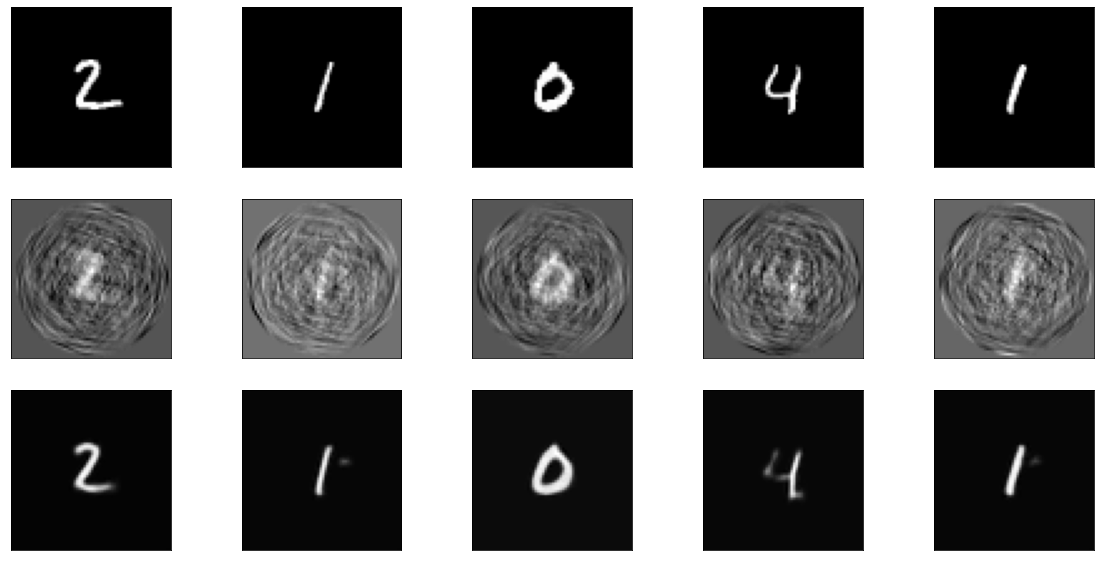

In [35]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_s3_3.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.savefig('subSampleSARTNeuralDecompressionNoise20.pdf')
#files.download('subSampleSARTNeuralDecompressionNoise20.pdf')

#### Remarks

Increasing the number of convolutional layers and increasing some of the filter sizes seemed to improve performance a bit. Some of the 4's strokes came back and overall the numbers look better.

# Section 4

The coded aperture tomography code presented in https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/codedApertureTomography.ipynb describes 2D reconstruction from 1D measurement data. Build a forward model for a system that measures a similar 2D object space from two different angles (e.g. with a coded aperture normal to the x-axis and a coded aperture normal to the y-axis.) How does this system perform compared to the single look system?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
from scipy import integrate
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist


## Single Measurement Vector

We consider an $N\times N$ object space a distance $l$ away from a 1D coded aperture, which is in turn a distance $d$ away from a detector array. The center position of the the $j^{th}$ element of the object is 
$$
p_j=[\Delta {\rm mod}(j,N),d+\Delta {\rm floor}(j/N)]
$$
The $j^{th}$ element projects the pattern
$$
g_j(x)=t\left (\frac{x+ \frac{l}{z_j}x_j}{1+\frac{l}{z_j}} \right )
$$
Measurements are discretely samples such that for the $i^{th}$ measurement we can define
$h_{ij}=\int g_j(x) {\rm rect}(x-i \Delta -x_o) dx$

$t(x)$ is defined over $x=[-\frac{P}{2} \Delta, \frac{P}{2} \Delta]$ and takes the form
$$
t(x)=\sum_{-\frac{P}{2}}^{\frac{P}{2}}t_p {\rm rect}(x-p\Delta ) 
$$
where $t_p$ is the code pattern.

### Load MNIST Image Database



In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


### Forward Model

In [ ]:
l= 10
delta=1
N=28
M=128
code=np.random.randint(0,2,M)
def t(x):
  t=code[int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+l
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def h(i,j):
  h=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return h
H=np.zeros((M,N**2))
for j in range(N**2):
  for i in range(M):
    H[i,j]=h(i,j)

#### Random Code Visibility

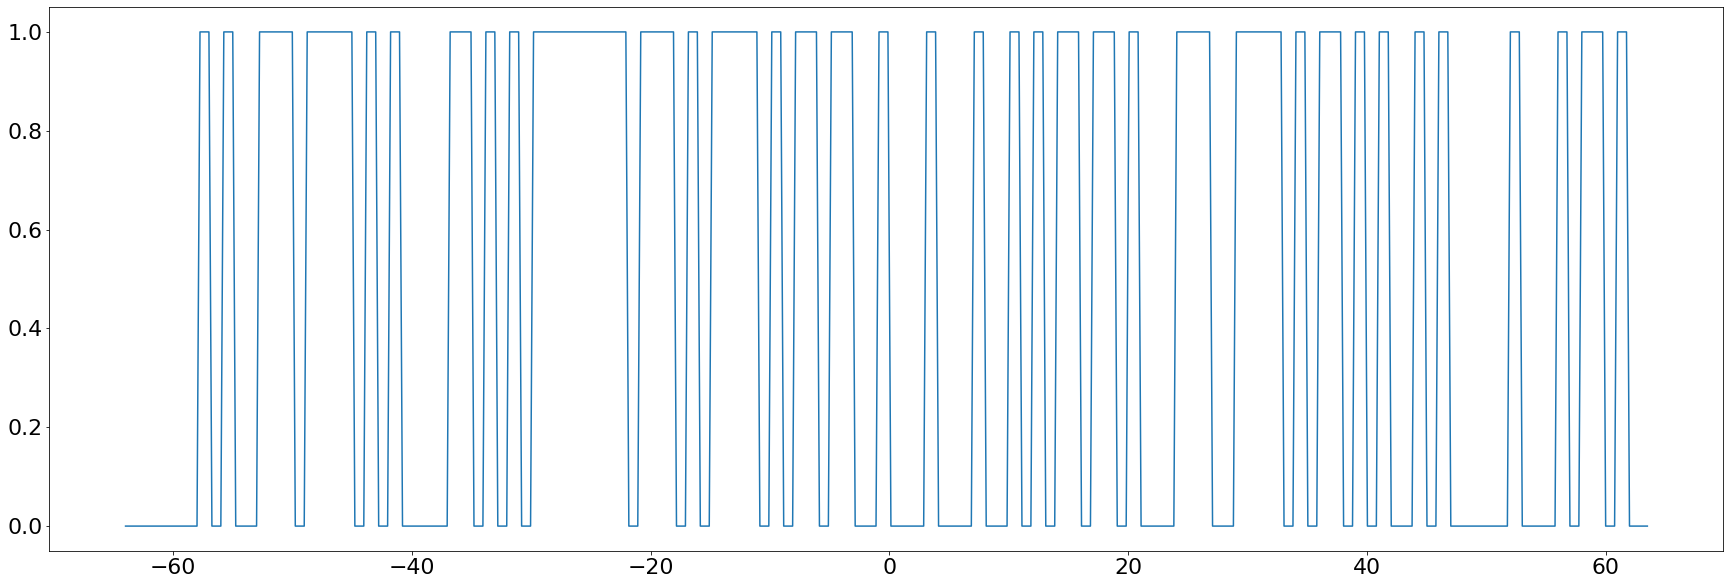

In [ ]:
xspace=np.linspace(-M*delta/2,(M-1)*delta/2,512)
plt.plot(xspace,vt(xspace))

#### Measurement Matrix, H

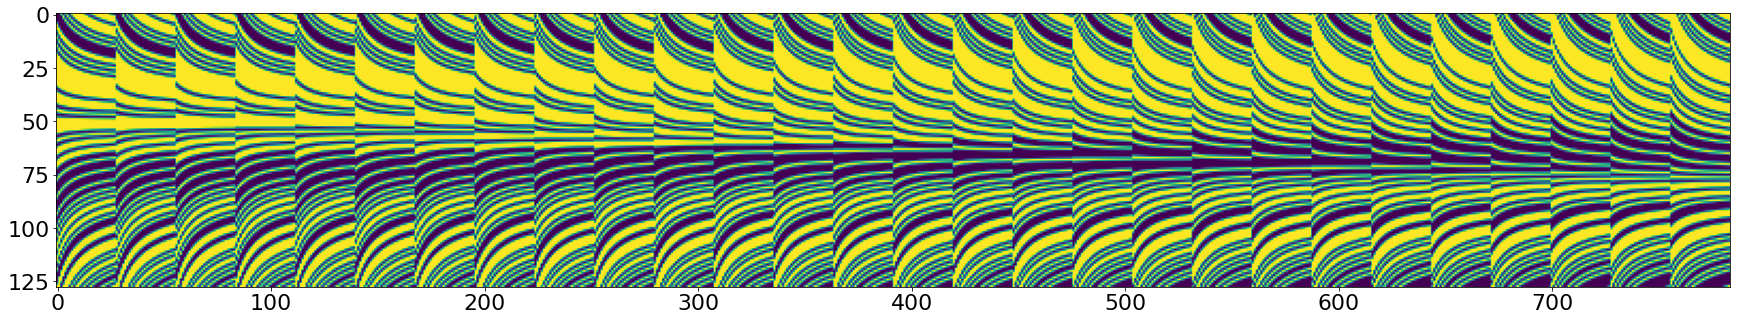

In [ ]:
plt.imshow(H)
#plt.savefig('codedApertureTomographyH.pdf')
#files.download('codedApertureTomographyH.pdf')

We can visualize the projection that each row of H makes on the N by N object space

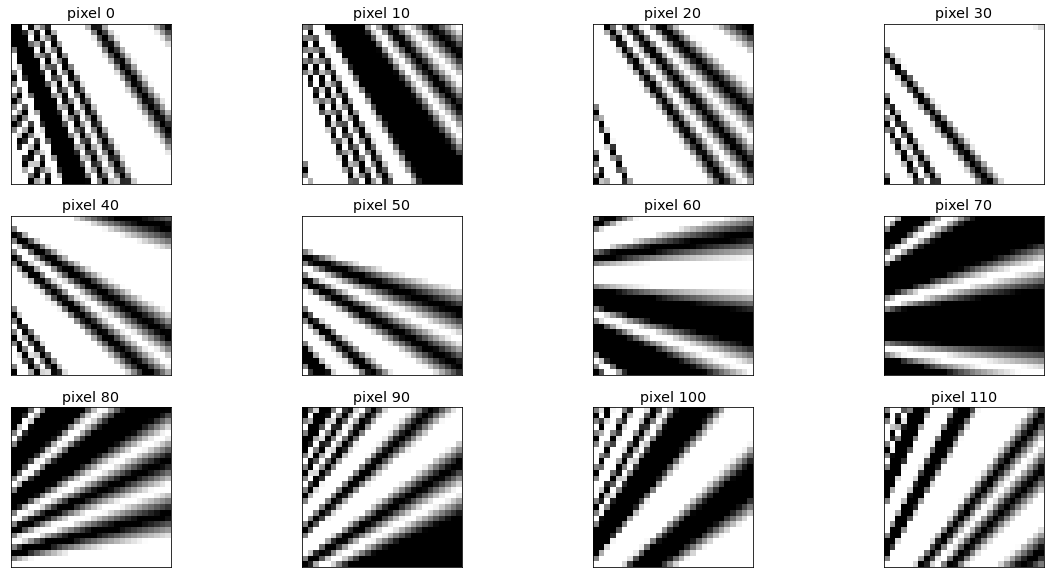

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12})
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(H[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('pixel '+str(10*i))
#plt.savefig('codedApertureTomographyMeasurements.pdf')
#files.download('codedApertureTomographyMeasurements.pdf')


In [ ]:
u, lam, vh = np.linalg.svd(H)
ph=np.linalg.pinv(H)

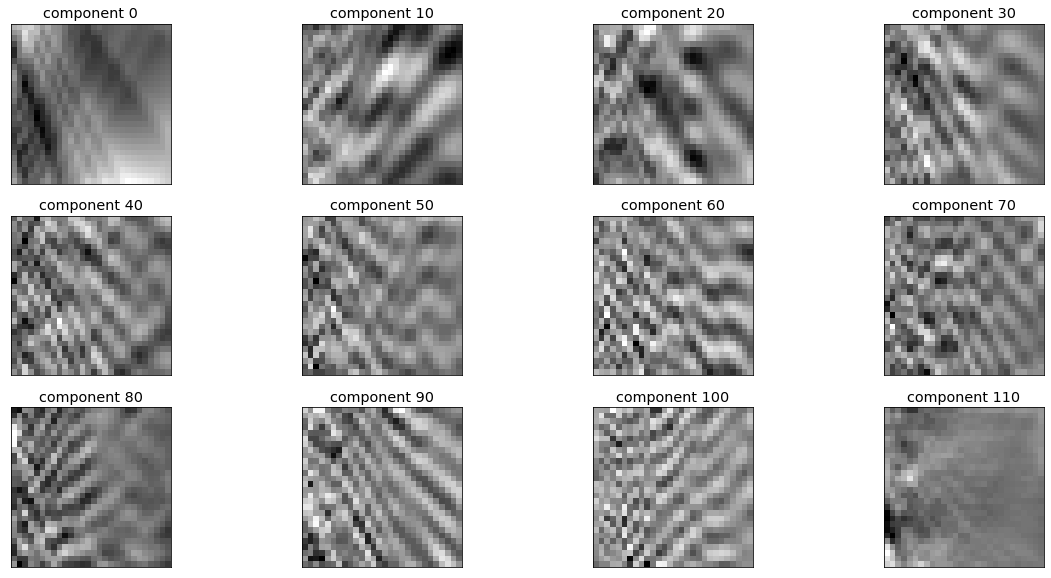

In [ ]:

plt.figure(figsize=(20, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(vh[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('component '+str(10*i))
#plt.savefig('codedApertureTomographySV.pdf')
#files.download('codedApertureTomographySV.pdf')


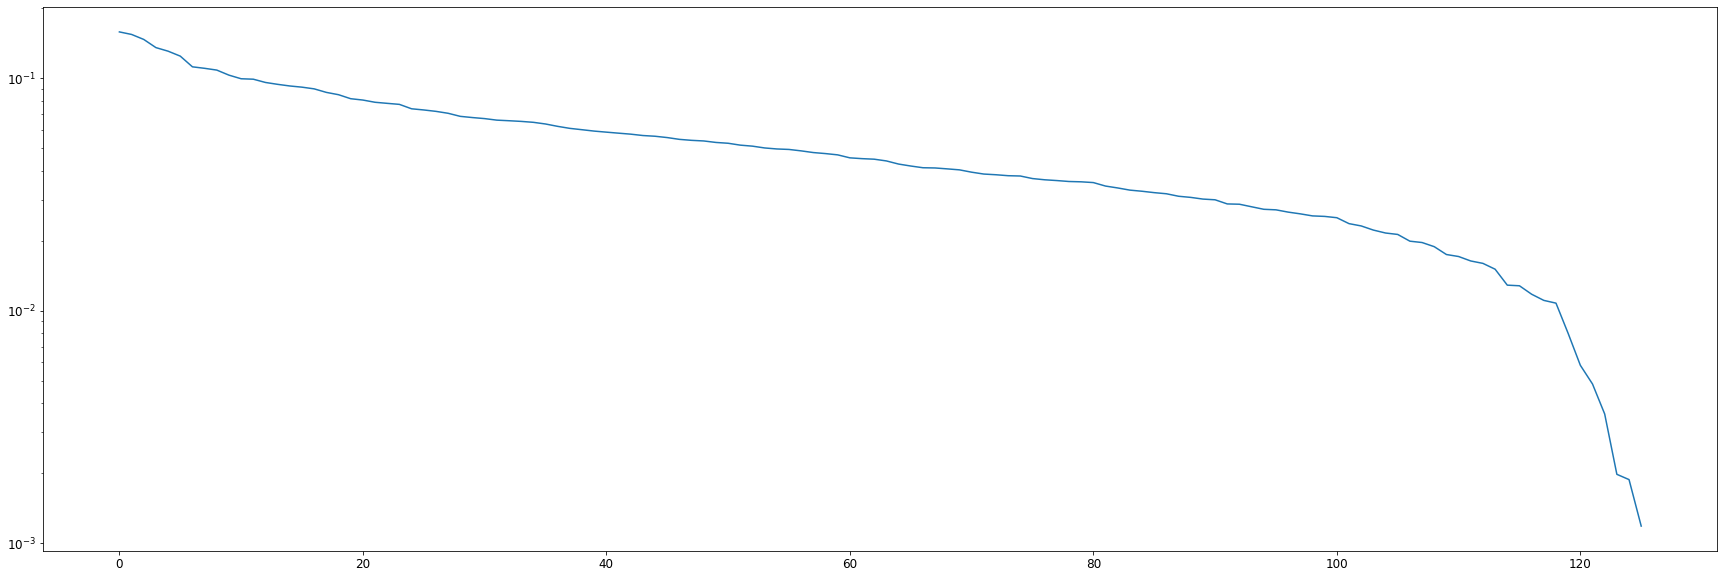

In [ ]:
plt.semilogy(lam[1:127]/lam[0])


### Neural Reconstruction

####  Prepare Training Data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))

for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_test[pop],N**2))),(N,N))
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])

for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_train[pop],N**2))),(N,N))
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])

x_train = np.reshape(x_train, (len(x_train), N, N, 1))
x_test = np.reshape(x_test, (len(x_test), N, N, 1))
g_train = np.reshape(g_train, (len(g_train), N, N, 1))
g_test = np.reshape(g_test, (len(g_test), N, N, 1))

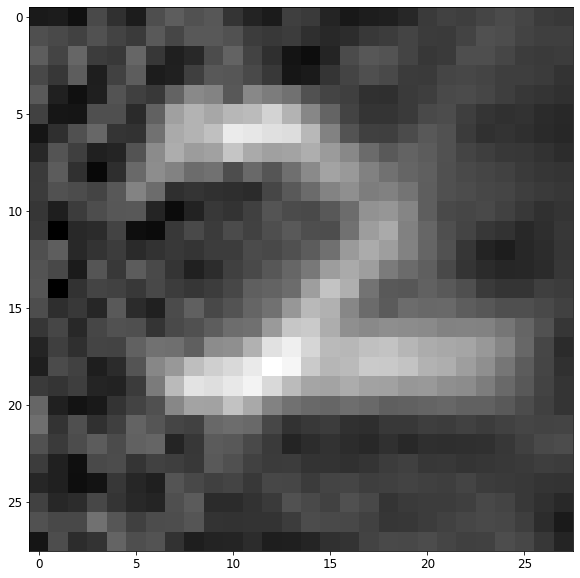

In [ ]:
plt.imshow(g_test[1932].reshape(N, N))

In [ ]:
!wget --no-check-certificate https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s4_1.tar.gz
!tar -xzvf autoencoder_s4_1.tar.gz
autoencoder_s4_1 = keras.models.load_model('autoencoder_s4_1/')

#### Encoder/Denoising Model

In [ ]:
inputs=keras.Input(shape=(N, N, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder_s4_1 = keras.Model(inputs, x)
autoencoder_s4_1.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_s4_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        16416     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                   

#### Training

In [ ]:
autoencoder_s4_1.fit(
    x=g_train,
    y=x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/30
469/469 [==============================] - 17s 15ms/step - loss: 0.0177 - val_loss: 0.0089
Epoch 2/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 3/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 4/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 5/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 7/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 8/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 9/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 10/30
469/469 [==============================] - 7s 14ms/step - loss: 0.0051 - val_l

In [ ]:
autoencoder_s4_1.save("autoencoder_s4_1")
!tar -czvf autoencoder_s4_1.tar.gz autoencoder_s4_1/
files.download('autoencoder_s4_1.tar.gz')

autoencoder_s4_1/
autoencoder_s4_1/variables/
autoencoder_s4_1/variables/variables.index
autoencoder_s4_1/variables/variables.data-00000-of-00001
autoencoder_s4_1/assets/
autoencoder_s4_1/saved_model.pb
autoencoder_s4_1/keras_metadata.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Reconstruction

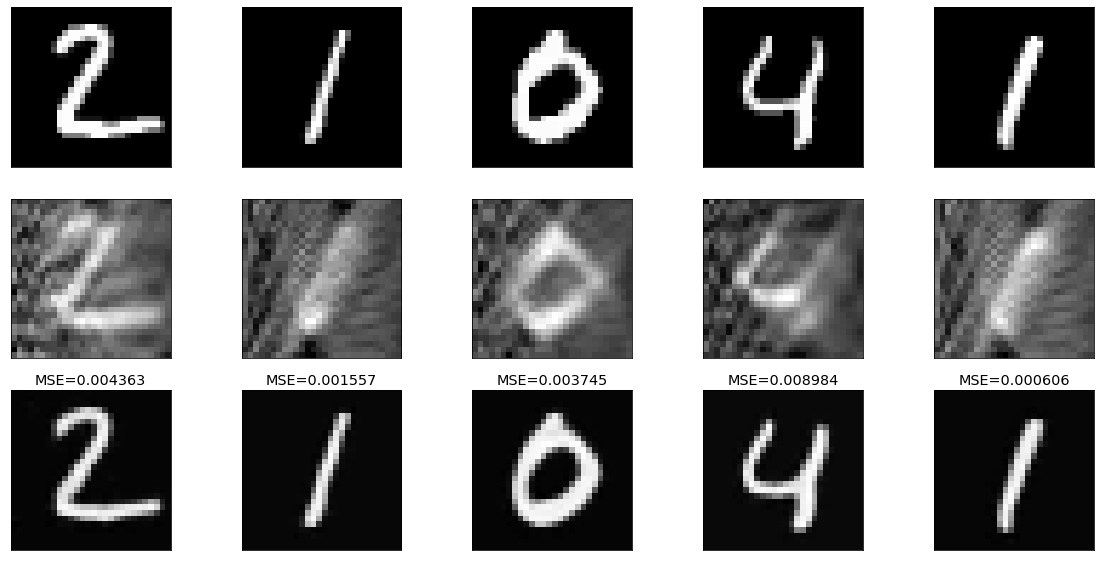

In [ ]:
n = 5
p = np.zeros((5,28,28))
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    p[i-1,:,:] = autoencoder_s4_1.predict(g_test[i:(i+1),:,:,:])[0,:,:,0]
    plt.imshow(p[i-1,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MSE=%f' %mean_squared_error(x_test[i].reshape(N, N),p[i-1,:,:]))
#plt.savefig('codedApertureTomography.pdf')
#files.download('codedApertureTomography.pdf')

## Two Measurement Vectors

The goal of this model is to create a measurement space that includes two measurement vectors. One vector is located normal to the x-axis, the other is normal to the y-axis.

A potential solution would be to create a new measurement matrix, $H_n$, which is a concatenation of $H$ and a shifted version of itself, $H_s$, along the row axis. The dimensions of $H_n$ are 256 x 784. $H_s$ is created by shifting the $x_j$'s and $z_j$'s in $t(x)$ to a location, $(x_{j'},z_{j'})$ , corresponding to a 90 degree rotation of the object space.

The new measured image, $\vec{I}$, is shown below in matrix form:

$$
\vec{I}_{256\times1} = 
\begin{bmatrix}
H_s \\
H
\end{bmatrix}_{256\times784}
\times \vec{g}_{784\times1}(x)
$$

In this exercise the object space is essentially imaged twice. The randomly-generated coded aperature is also replicated for the second measurement vector. The resulting measurement vector will not, however, be a redundant concatenation of the single measurement vector with itself. This is due to the effect of rotation on one of the measurement vectors; it changes which elements in the object space influence a particular location on the vector. In other words, the elements contributing to $g_j(x)$ will differ from the elements contributing to $g_{j+128}(x)$.

Perfect reconstruction of the object space, $\vec{g}(x)$, is not possible since the two-sided inverse of $H_n$ does not exist. Instead, an estimate of $\vec{g}(x)$, $\hat{g}(x)$, can be obtained by calculating the Moore-Penrose pseudo-inverse, $H_n^\dagger$.

$$
\hat{g}_{784\times1}(x) = H_{n,784\times256}^\dagger \times \vec{I}_{256\times1}
$$


The steps to implementing this solution are as follows:

1. Measure the object space using a single measurement vector and form an image, $\vec{I}_1$:

$$
\vec{I}_1 = H_{128\times784}\times\vec{g}_{784\times1}(x)
$$

2. Rotate the object space 90 degrees. This rotation can be performed by applying an operator, $A$, to $\vec{g}(x)$ such that:

$$
A\vec{g}(x) → \vec{g}_r(x)
$$

3. Measure the rotated object space using a single measurement vector and form an image, $\vec{I}_2$:

$$
\vec{I}_2 = H_{128\times784}\times \vec{g}_r(x) = H_{128\times784}\times A\vec{g}(x)
$$

4. Create a new image matrix, $I_n$, and measurement matrix, $H_n$:

$$
I_n = 
\begin{bmatrix}
\vec{I}_1 \\
\vec{I}_2
\end{bmatrix},H_n =
\begin{bmatrix}
H \\
HA
\end{bmatrix}
$$

5. If the estimate of $\vec{g}(x)$ is $\hat{g}(x)$, then:

$$
\hat{g}_{784\times1}(x) = H_{n,784\times256}^\dagger \times \vec{I}_{256\times1}
$$


### Load MNIST Image Database



In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

### Forward Model

This method will use the same forward model for a single measurement vector.

### Measure the Object Space

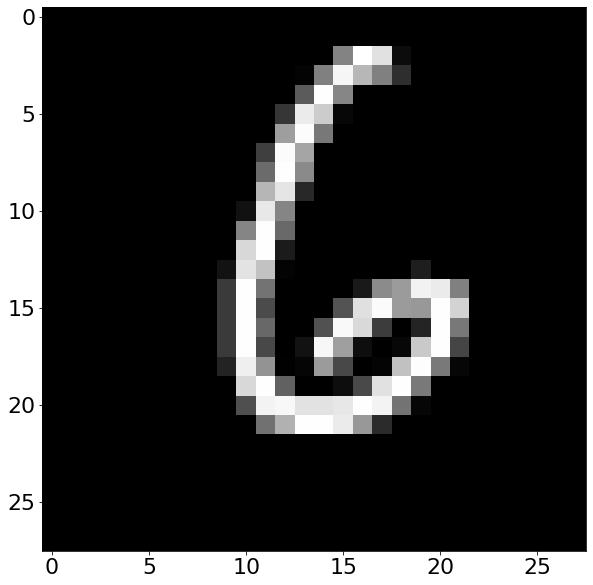

In [ ]:
plt.imshow(x_train[32],cmap='gray')

#### Function to Generate the Rotation Matrix

In [ ]:
def buildA(N):
  # This function builds a matrix that will rotate a raster-represented matrix
  # 90 deg clockwise
  M = N**2
  # Rotation Matrix is size N^2 x N^2
  a = np.zeros((M,M)).astype('int')

  # Template matrix of size N*N
  #   Reshaped to a NxN matrix
  #   The "1" is shifted every iteration and the entire template is inserted
  #   into the final rotation maxtrix
  tmp = np.zeros(M).astype('int')
  tmp[-1] = 1

  # Ex:
  #   tmp:
  #       |0 0|
  #       |0 1|
  #
  #   is inserted into the first location in A
  #
  #   A:
  #        0 0 0 0
  #        0 0 0 0
  #  tmp=>|0 0|0 0
  #       |0 1|0 0
  #
  #   tmp is then shifted one to the left and inserted in the next spot
  #
  #   A:
  #  tmp=>|0 0|0 0
  #       |1 0|0 0
  #        0 0 0 0
  #        0 1 0 0
  #
  #   and so on. Not sure how the math works out but this pattern ends up
  #   working at any scale.

  for j in range(0,M,N):
    for i in range(0,M,N):
      a[(M-i-N):(M-i),j:(j+N)] = np.reshape(tmp,(N,N))
      tmp = np.roll(tmp,-1)

  return a

In [ ]:
# make junk square matrix for test
h = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
print(h)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]


In [ ]:
# create A matrix for rotation
A = buildA(4)
print(A)

[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
# test A matrix: small test
N,c = h.shape
x = np.reshape(np.matmul(A,np.reshape(h,(N**2,1))),(N,N))
print(x)

[[13  9  5  1]
 [14 10  6  2]
 [15 11  7  3]
 [16 12  8  4]]


#### Measure Object Space

In [ ]:
# multiply object by H to create first measurement
N,c = x_train[32].shape
I1 = np.matmul(H,np.reshape(x_train[32],N**2))

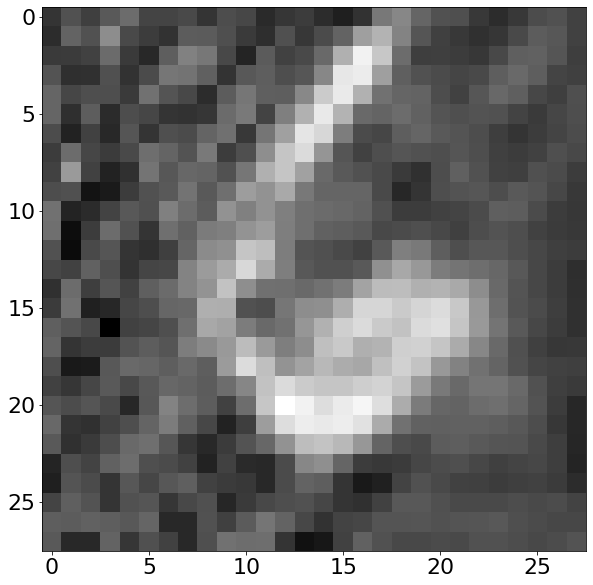

In [ ]:
# reconstruct image using linear reconstruction
plt.imshow(np.reshape(np.matmul(np.linalg.pinv(H),I1),(N,N)),cmap='gray')

#### Measure Rotated Object Space

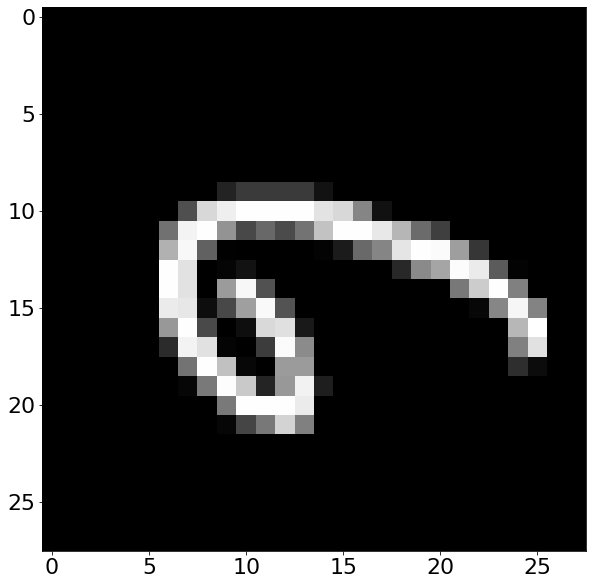

In [ ]:
# rotate object 90deg cw
N,c = x_train[32].shape
A = buildA(N)
xRotated = np.matmul(A,np.reshape(x_train[32],(N**2,1)))
plt.imshow(np.reshape(xRotated,(N,N)),cmap='gray')

In [ ]:
# multiply rotated object by H to create second image
I2 = np.matmul(H,np.reshape(xRotated,N**2))

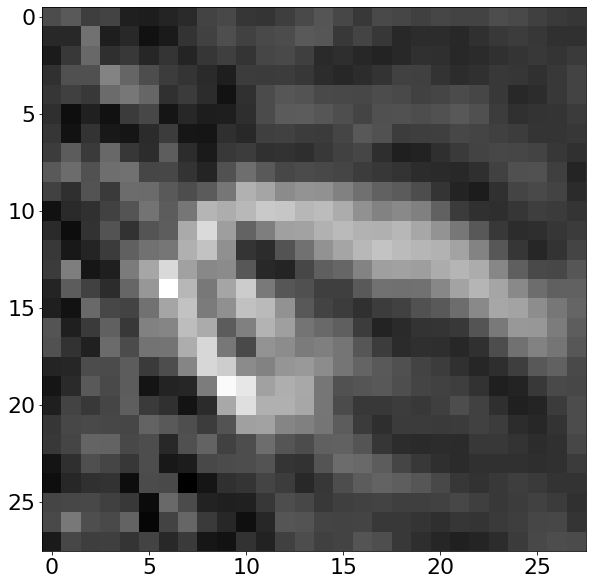

In [ ]:
# reconstruct image using linear reconstruction
plt.imshow(np.reshape(np.matmul(np.linalg.pinv(H),I2),(N,N)),cmap='gray')

### Linear Reconstruction

In [ ]:
In = np.concatenate((I1,I2))
Hn = np.concatenate((H,np.matmul(H,A)))
HnInv = np.linalg.pinv(Hn)
gHat = np.reshape(np.matmul(HnInv,In),(N,N))

We can visualize the projection that each row of Hn makes on the N by N object space

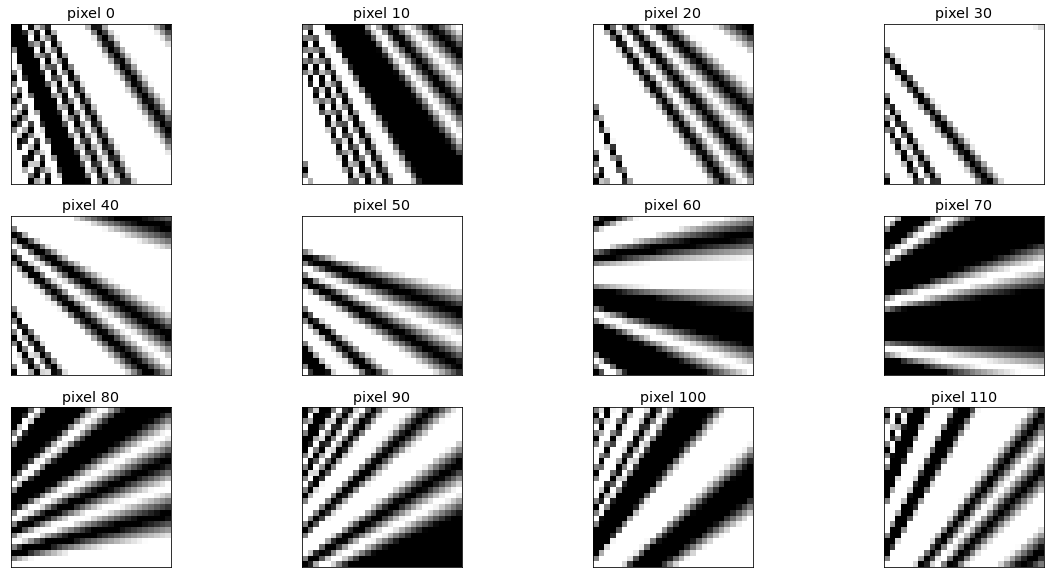

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12})
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(Hn[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('pixel '+str(10*i))
#plt.savefig('codedApertureTomographyMeasurements.pdf')
#files.download('codedApertureTomographyMeasurements.pdf')


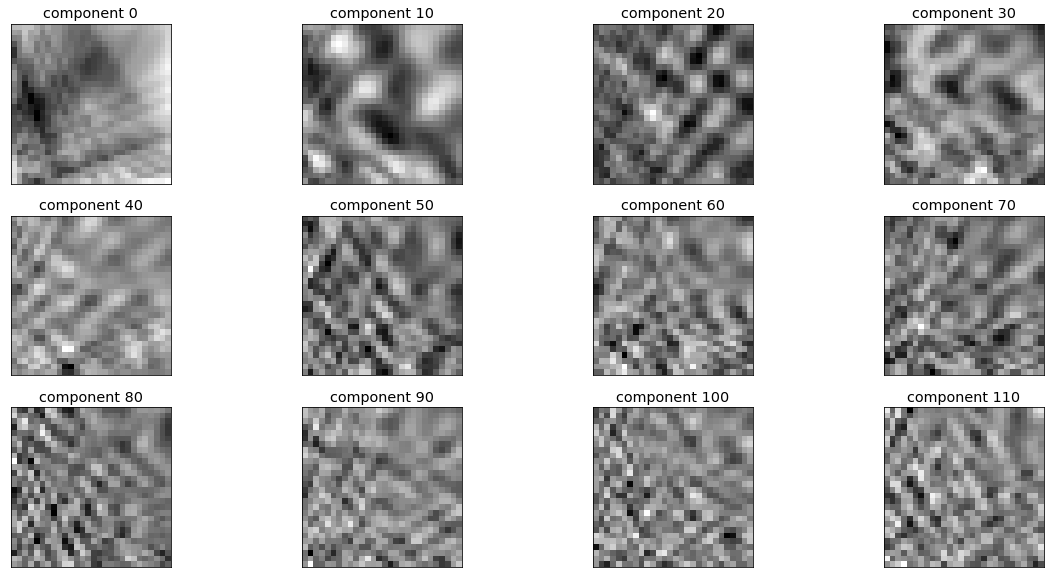

In [ ]:
u, lam, vh = np.linalg.svd(Hn)
plt.figure(figsize=(20, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(vh[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('component '+str(10*i))
#plt.savefig('codedApertureTomographySV.pdf')
#files.download('codedApertureTomographySV.pdf')


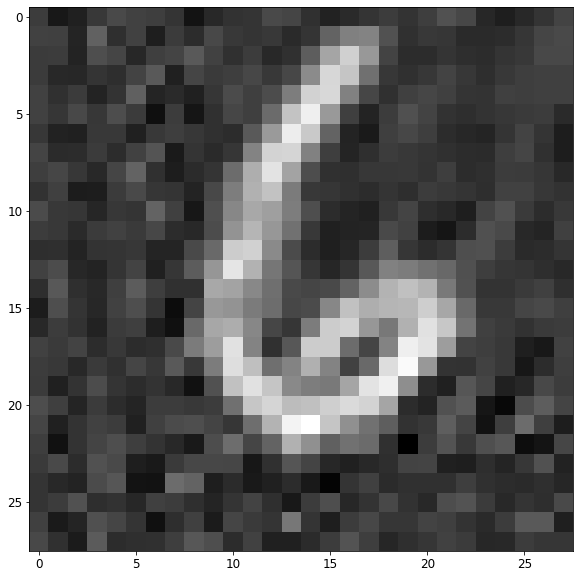

In [ ]:
plt.imshow(gHat,cmap='gray')

#### Remarks
Linear reconstruction of the two measurement vectors leaves less blur than before. In the single measurement vector case, half of the reconstructed image was blurred due to the relative distance of the measurement vector to the elements of the object space. In the two measurement vectors case, only one quadrant of the image is blurry. This is due to being able to measure half of those blurry elements at a closer range. The second image that is captured causes those blurry elements to sort of wash out and leaves them at a better resolution than before.

### Neural Reconstruction

####  Prepare Training Data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))

for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= np.reshape(np.matmul(HnInv,np.matmul(Hn,np.reshape(x_test[pop],N**2))),(N,N))
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])

for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=np.reshape(np.matmul(HnInv,np.matmul(Hn,np.reshape(x_train[pop],N**2))),(N,N))
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])

x_train = np.reshape(x_train, (len(x_train), N, N, 1))
x_test = np.reshape(x_test, (len(x_test), N, N, 1))
g_train = np.reshape(g_train, (len(g_train), N, N, 1))
g_test = np.reshape(g_test, (len(g_test), N, N, 1))

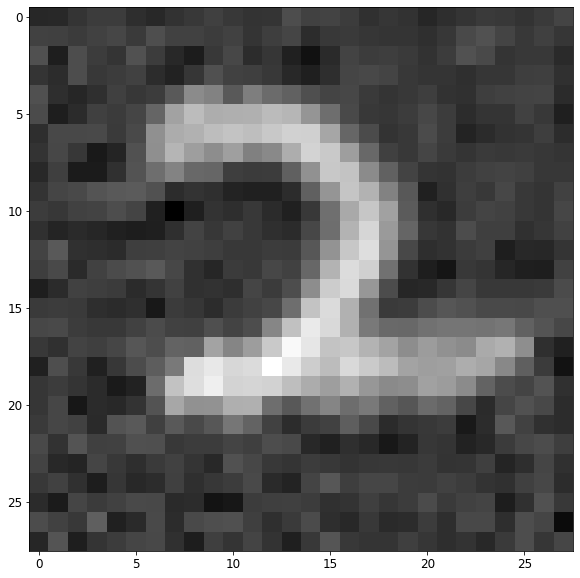

In [ ]:
plt.imshow(g_test[1932].reshape(N, N),cmap='gray')

In [ ]:
!wget --no-check-certificate https://github.com/sthoesen/OPTI556/raw/main/assignment3/autoencoder_s4_2.tar.gz
!tar -xzvf autoencoder_s4_2.tar.gz
autoencoder_s4_2 = keras.models.load_model('autoencoder_s4_2/')

#### Encoder/Denoising Model

In [ ]:
inputs=keras.Input(shape=(N, N, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder_s4_2 = keras.Model(inputs, x)
autoencoder_s4_2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_s4_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        16416     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                 

#### Training

In [ ]:
autoencoder_s4_2.fit(
    x=g_train,
    y=x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/30
469/469 [==============================] - 7s 14ms/step - loss: 0.0124 - val_loss: 0.0036
Epoch 2/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 3/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0021 - val_lo

In [ ]:
autoencoder_s4_2.save("autoencoder_s4_2")
!tar -czvf autoencoder_s4_2.tar.gz autoencoder_s4_2/
files.download('autoencoder_s4_2.tar.gz')

autoencoder_s4_2/
autoencoder_s4_2/variables/
autoencoder_s4_2/variables/variables.index
autoencoder_s4_2/variables/variables.data-00000-of-00001
autoencoder_s4_2/assets/
autoencoder_s4_2/saved_model.pb
autoencoder_s4_2/keras_metadata.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Reconstruction

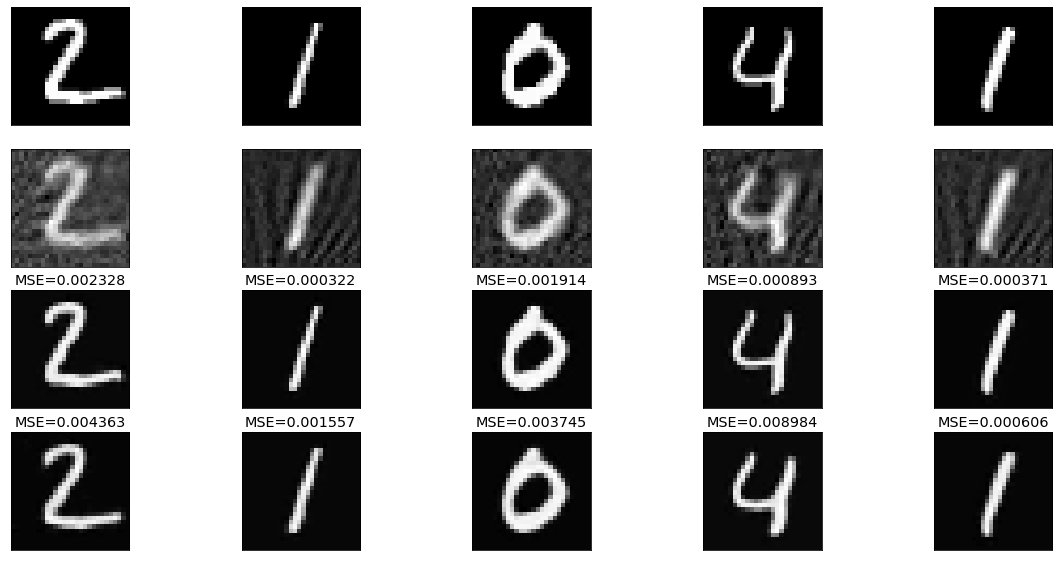

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12})
for i in range(1, n + 1):
    ax = plt.subplot(4, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4, n, n+i)
    plt.imshow(g_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4, n, 2*n+i)
    q = autoencoder_s4_2.predict(g_test[i:(i+1),:,:,:])[0,:,:,0]
    plt.imshow(q)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MSE=%f' %mean_squared_error(x_test[i].reshape(N, N),q))
    ax = plt.subplot(4, n, 3*n+i)
    plt.imshow(p[i-1,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MSE=%f' %mean_squared_error(x_test[i].reshape(N, N),p[i-1,:,:]))
#plt.savefig('codedApertureTomography.pdf')
#files.download('codedApertureTomography.pdf')

#### Remarks

The third row above corresponds to neural reconstruction using linear reconstructions of the two measurement vectors case. The fourth row above corresponds to neural reconstruction using linear reconstructions of the single measurement vector case.

The reconstruction quality of a sparse image is relatively good in both cases. Both cases result in low MSE and the images look very similar, if not identical. As expected, the two measurement vector case has better MSE. This is due to less blurry linear reconstructions. 